In [102]:
# -*- coding: utf-8 -*-
import os
import math
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy.optimize import minimize
from datetime import datetime




## Algorithm

![xx](figure/algorithms.png)

In [103]:
# set a seed so that the results are reproducible
def set_random_seeds(seed_value):

    np.random.seed(seed_value)
    random.seed(seed_value)

## Obstacle Design

In [104]:
class Obstacle:
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        self.obstacle_positions = np.array(obstacle_positions)
        self.obstacle_radius = np.array(obstacle_radius)
        self.obs_cost = obs_cost
        self.boundary_x = boundary_x
        self.boundary_y = boundary_y

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            cost += float(x_curr[0] > op[0] and x_curr[0] < op[0] + self.obstacle_radius[obs_i] and
                          x_curr[1] > op[1] and x_curr[1] < op[1] + self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def compute_boundary_penalty(self, x_curr):
        return float(x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or
                     x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]) * self.obs_cost

    def check_hit_obstacle(self, x_curr):
        for pos, r in zip(self.obstacle_positions, self.obstacle_radius):
            if (x_curr[0] > pos[0] and x_curr[0] < pos[0] + r and x_curr[1] > pos[1] and x_curr[1] < pos[1] + r):
                return True
        return False

    def check_hit_boundary(self, x_curr):
        return x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class CircleObstacle(Obstacle):
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        super().__init__(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            distance_to_center = np.sqrt((x_curr[0] - op[0])**2 + (x_curr[1] - op[1])**2)
            cost += float(distance_to_center <= self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Circle(obs_pos, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class PolygonObstacle(Obstacle):
    def __init__(self, obstacle_positions, boundary_x, boundary_y, obs_cost):
        # Here, obstacle_positions should be a list of vertices for each polygon
        super().__init__(obstacle_positions, None, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            polygon = Polygon(self.obstacle_positions[obs_i])
            cost += float(polygon.contains_point(x_curr)) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos in self.obstacle_positions:
            obs = Polygon(obs_pos, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class Map:
    def __init__(self, obstacles):
        self.obstacles = obstacles

    def compute_total_obstacle_cost(self, x_curr):
        total_cost = 0
        for obstacle in self.obstacles:
            total_cost += obstacle.compute_obstacle_cost(x_curr)
        return total_cost

    def compute_total_boundary_penalty(self, x_curr):
        total_penalty = 0
        for obstacle in self.obstacles:
            total_penalty += obstacle.compute_boundary_penalty(x_curr)
        return total_penalty

    def check_hit_any_obstacle(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_obstacle(x_curr):
                return True
        return False

    def check_hit_any_boundary(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_boundary(x_curr):
                return True
        return False

    def plot_map(self, ax):
        for obstacle in self.obstacles:
            obstacle.plot_obstacles(ax)


    



## Dynamics
We consider a continuous-time and continuous-space stochastic process $\bm x(t)\in\mathbb{R}^{n}$ satisfying a control affine dynamic system, as follows:  

$$\begin{equation}
    d\bm x(t) = f\left(\bm x(t),t\right)dt + \bm G\left(\bm x(t),t\right)
    \bm u(\bm x(t),t)dt +  \bm \Sigma(\bm x(t), t) d\bm \xi(t) .
\end{equation}$$

Here, $f\left(\bm x(t),t\right)\in \mathbb{R}^n$ is a nonlinear passive dynamic, $\bm u(\bm x(t),t)\in \mathbb{R}^{p}$ is a control input, a control transition matrix $\bm G(\bm x(t),t)\in\mathbb{R}^{n\times p}$ is a full rank matrix-valued function with $n\geq p$. In addition, $\bm \xi(t)\in\mathbb{R}^{k}$ is a diffusion process and $\Sigma(\bm x(t), t)\in\mathbb{R}^{n\times k}$ is a diffusion matrix that maps the noise to the state. We consider $\bm \xi(t)\in\mathbb{R}^{k}$ as a drifted diffusion process which is defined as $d\bm \xi(t) = \bm \mu\left(\bm x(t),t\right)dt + d\bm w(t)$.  $d\bm w(t)$ is the increment of a standard Wiener process and the drift term $\bm \mu(\bm x, t)\in\mathbb{R}^{k}$ is the deterministic component that influences the expected rate of change of the process. Hence, $\bm \mu(\bm x, t)$  can be interpreted as a systemic bias in the evolution of the stochastic process over time.

In [105]:
class Dynamics_Linearized:
    def __init__(self, F, G, S):
        self.F = F
        self.G = G
        self.S = S

    def compute_next_state(self, state, control, noise):
        return self.F @ state + self.G @ control + self.S @ noise

In [106]:
class Dynamics_Nonlinear:
    def __init__(self, dt):
        self.dt = dt

    def compute_next_state(self, state, control, noise):
        next_state = np.zeros_like(state)
        next_state[0] = state[0] + self.dt * (control[0] + noise[0]) * np.cos(state[2])
        next_state[1] = state[1] + self.dt * (control[0] + noise[0]) * np.sin(state[2])
        next_state[2] = state[2] + self.dt * (control[1] + noise[1])
        return next_state

## Sampling

In [107]:
def estimate_mu(N):
    return np.mean(np.random.multivariate_normal(true_mu, Sigma, N), axis=0)

def sample_noise(Sigma, T=10.0, dt=0.5, num_trajs=500, n=2) :
    time_steps = int(T/dt)
    estimated_mu = estimate_mu(num_trajs)
    noise_samples = np.random.multivariate_normal(estimated_mu, Sigma , [num_trajs, time_steps])
    return noise_samples

## Rollout

In [108]:
def stage_cost(dist2, dist_weight = 10) :
    return dist_weight*dist2

def term_cost(dist2, goal_reached) :
    return (1 - float(goal_reached)) * dist2

def compute_next_state(x_curr, u_curr, noise, dt):
    return F @ x_curr + G @ (u_curr + noise) 

def rollout(dynamics, obstacles, initial_state, goal_state, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost=10, num_trajs=500, goal_tolerance=0.1):
    costs = np.zeros(num_trajs)
    # time_steps = len(u_curr) # Haven't defined u_curr yet
    time_steps = int(T//dt)
    goal_reached = False
    goal_tolerance_sq = goal_tolerance ** 2
    dist_to_goal = 1e9
    
    x_vis = np.zeros( (20, time_steps, 2) )*np.nan
    
    for k in range(num_trajs):
        #x_curr = np.zeros(n)
        #for i in range(n) :
        #    x_curr[i] = initial_state[i]
        x_curr = initial_state.copy()
        if k < 20 :
            x_vis[k, 0, :] = x_curr[:2]
            
        for t in range(time_steps):
            
            # Compute next state
            x_curr = dynamics.compute_next_state(x_curr, [0, 0], noise_samples[k, t, :])
            
            if k < 20:
                x_vis[k, t, :] = x_curr[:2]
                
            dist_to_goal = (goal_state[0]-x_curr[0])**2 + (x_goal[1]-x_curr[1])**2
            
            # Calculate stage cost
            costs[k] += stage_cost(dist_to_goal, dist_weight)
            
            if dist_to_goal < 0.01 :
                break
            
            # Calculate obstacle cost
            costs[k] += obstacles.compute_obstacle_cost(x_curr)
                
            # Calculate boundary penalty
            costs[k] += obstacles.compute_boundary_penalty(x_curr)
                
            if dist_to_goal <= goal_tolerance_sq:
                goal_reached = True
                break
            
            # Terminal cost
            costs[k] += term_cost(dist_to_goal, goal_reached) 
    return costs, x_vis

## Optimization

In [109]:
def calculate_new_control_sequence(costs, lambda_, noise_samples):
    costs = np.exp(-costs / lambda_)
    sum_costs = np.sum(costs)

    time_steps, n = noise_samples.shape[1:3]
    u_curr = np.zeros((time_steps, n))
    for k in range(len(costs)):
        u_curr[0, :] += (costs[k] / sum_costs) * noise_samples[k, 0, :]
    
    return u_curr
    


In [110]:
def update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2) :
    return calculate_new_control_sequence(costs, lambda_neut, noise_samples)

def update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :    
    num_trajs = len(noise_samples)
    for gamma in gammas :
        lambda_l = 1e-3; lambda_r = 1e3
        # theta_l = -1e10; theta_r = 1e10 
        k = 0
        K = 300        
        while k < K :
            lambda_1 = lambda_l + (lambda_r - lambda_l) / 3
            lambda_2 = lambda_l + 2 * (lambda_r - lambda_l) / 3
            
            opt_cost_1 = gamma / lambda_1 - lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) )
            opt_cost_2 = gamma / lambda_2 - lambda_2 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_2 )  ) )
            # print(- lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) ))
            
            if opt_cost_1 > opt_cost_2:
                lambda_l = lambda_1
            elif opt_cost_1 < opt_cost_2 :
                lambda_r = lambda_2
            
            if lambda_r - lambda_l <= 1e-3:
                break
            
            optimal_cost = min(opt_cost_1, opt_cost_2)
            k += 1
    
    return calculate_new_control_sequence(costs, lambda_r, noise_samples)

def update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :
    num_trajs = len(noise_samples)
    lambda_grid = np.linspace(1e-3, 1e3, num_trajs)  # grid of lambda values
    for gamma in gammas :
        opt_costs = []
        for lambda_ in lambda_grid:
            opt_cost = gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
            opt_costs.append(opt_cost)
        lambda_r = lambda_grid[np.argmin(opt_costs)]  # Select the lambda that gives the minimum cost

        return calculate_new_control_sequence(costs, lambda_r, noise_samples)

def update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2):
    num_trajs = len(noise_samples)

    # Define the cost function wrapper
    def opt_cost_func(lambda_, gamma, costs, num_trajs):
        return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
        # return lambda_ / gamma  + 1 / lambda_ * np.log(1 / num_trajs * np.sum(np.exp(costs * lambda_)))

    for gamma in gammas:
        # Alternatively, use the Nelder-Mead method.  'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'
        result = minimize(opt_cost_func, x0=1.0, args=(gamma, costs, num_trajs), method='Powell', options={'maxiter': 10000})

        if result.success:
            lambda_r = result.x[0]
        else:
            print("Optimization failed for gamma =", gamma)
            continue  # Move on to the next gamma if optimization failed

        return calculate_new_control_sequence(costs, lambda_r, noise_samples)


## Path Integral

In [111]:
def path_integral(dynamics, obstacles, Sigma, initial_state, x_goal, u_curr, dist_weight, obs_cost, obs_pos, obs_r, T, dt, theta, num_trajs, init_report, gammas, method):
    
    noise_samples = sample_noise(Sigma, T, dt, num_trajs, n=2)
    costs, x_vis = rollout(dynamics, obstacles, initial_state, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost, num_trajs, goal_tolerance=0.1)   
    
    if method == 'DR Non':
        u_curr = update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2)
    elif method == 'DR bisection':
        u_curr = update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    elif method == 'DR grid_search':
        u_curr = update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    elif method == 'DR NM':
        u_curr = update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return u_curr, x_vis


# Model parameters

In [112]:
## Obstacles design
obstacle_positions = np.array([[-2.5, 0.0]])
obstacle_radius = np.array([2.0])

obs_cost = 1e3

boundary_x = [-4.0, 1.0]
boundary_y = [-1.0, 4.0]

obstacles = Obstacle(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)
circle_obstacle = CircleObstacle(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

environment = Map([obstacles])

## Dynamics design
T = 10.0
dt = 0.1

F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
        
G= np.array([[(dt**2)/2, 0],
             [0, (dt**2)/2],
             [dt, 0],
             [0, dt]])

dynamics = Dynamics_Linearized(F, G, G)

## Cost design

## Uncertainty design
set_random_seeds(0)

true_mu = np.array([0.003, 0.003])
Sigma = np.array([[0.01, 0.0], 
                  [0.0, 0.01]])


method = 'DR NM' # method = 'DR Non', 'DR bisection', 'DR grid_search', 'DR NM'

n_data = 10
num_simulation = 10
max_steps = 600
num_trajs = 30

dist_weight = 0.01

gamma = [300]

theta = 0.01
goal_tolerance = 0.1

x_init = np.array([-3.0, 3.0, 0, 0])
x_goal = np.array([0,0])
x_hists = np.zeros((num_simulation, max_steps+1, 2))*np.nan

success_time = []
success_index = []
fail_index = []

/tmp/ipykernel_7251/2393299104.py:49: RuntimeWarning: divide by zero encountered in log
  return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))


/home/claus/miniconda3/envs/Lab/lib/python3.11/site-packages/scipy/optimize/_optimize.py:3382: RuntimeWarning: invalid value encountered in scalar subtract
  t = 2.0*(fx + fx2 - 2.0*fval)
/home/claus/miniconda3/envs/Lab/lib/python3.11/site-packages/scipy/optimize/_optimize.py:3383: RuntimeWarning: invalid value encountered in subtract
  temp = (fx - fval - delta)
/home/claus/miniconda3/envs/Lab/lib/python3.11/site-packages/scipy/optimize/_optimize.py:3386: RuntimeWarning: invalid value encountered in scalar multiply
  t -= delta*temp*temp


Hit obstacle


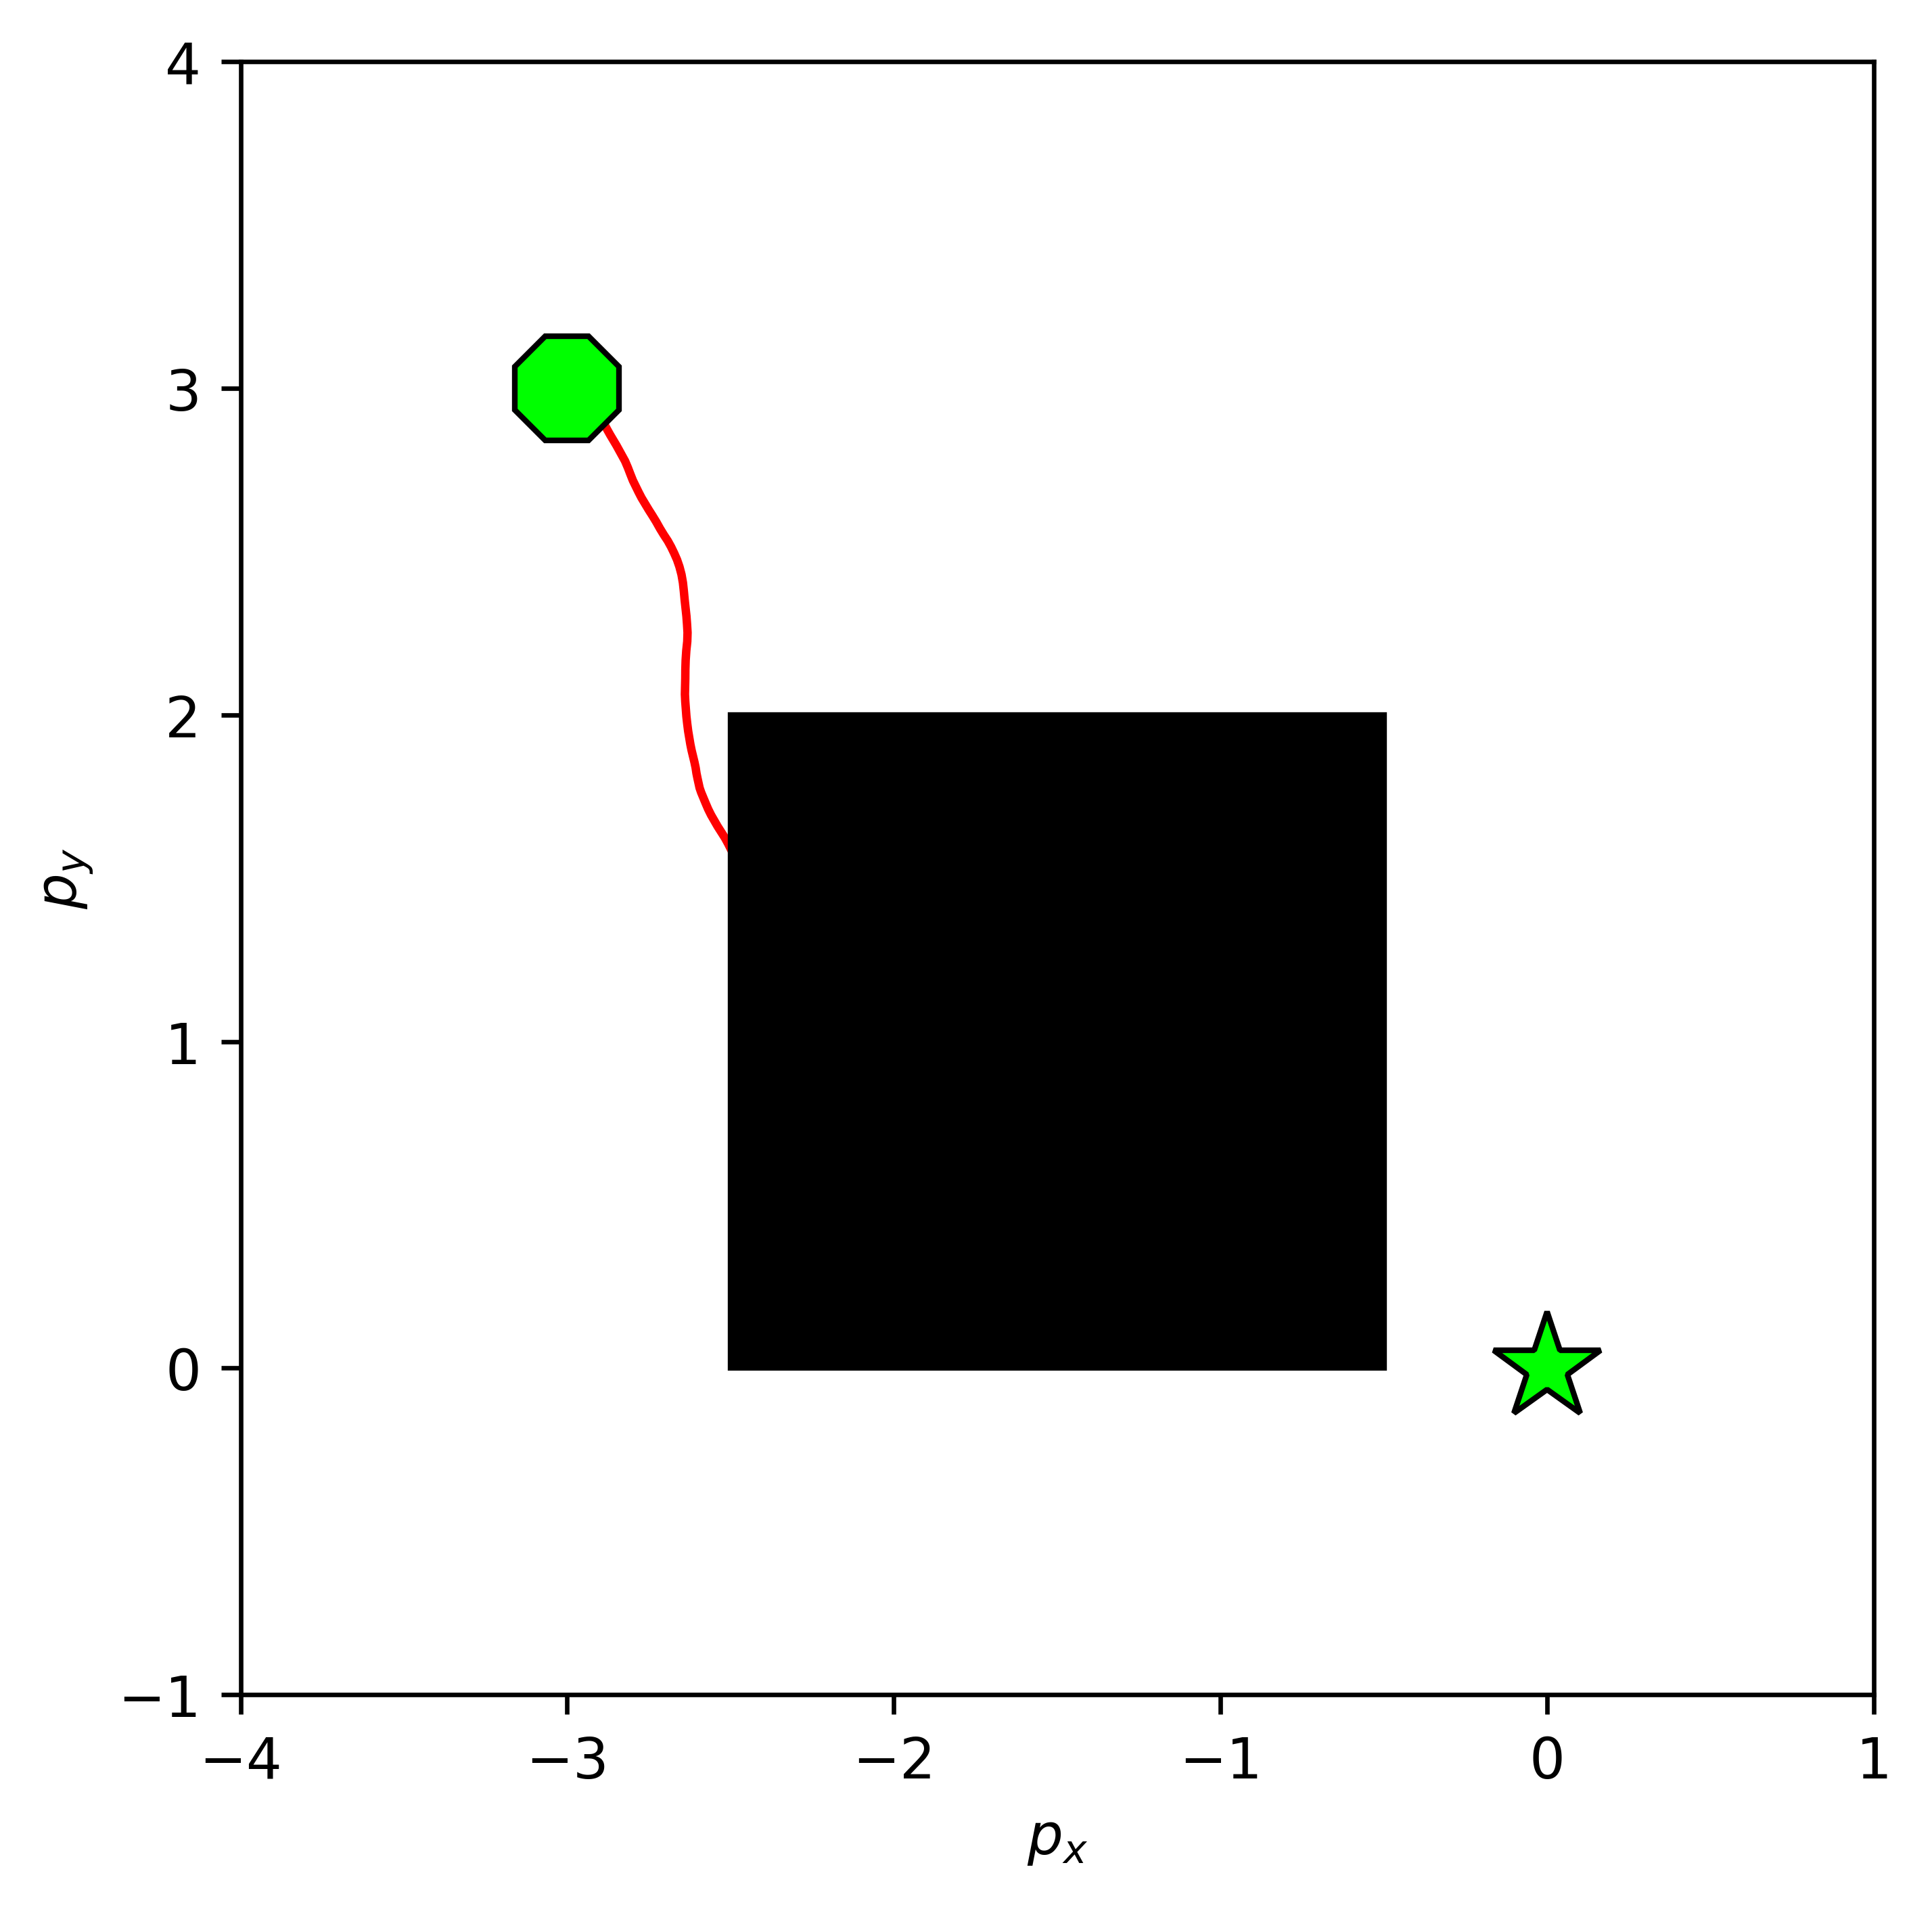

/tmp/ipykernel_7251/2393299104.py:49: RuntimeWarning: overflow encountered in exp
  return gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))


Goal reached at t=30.6s


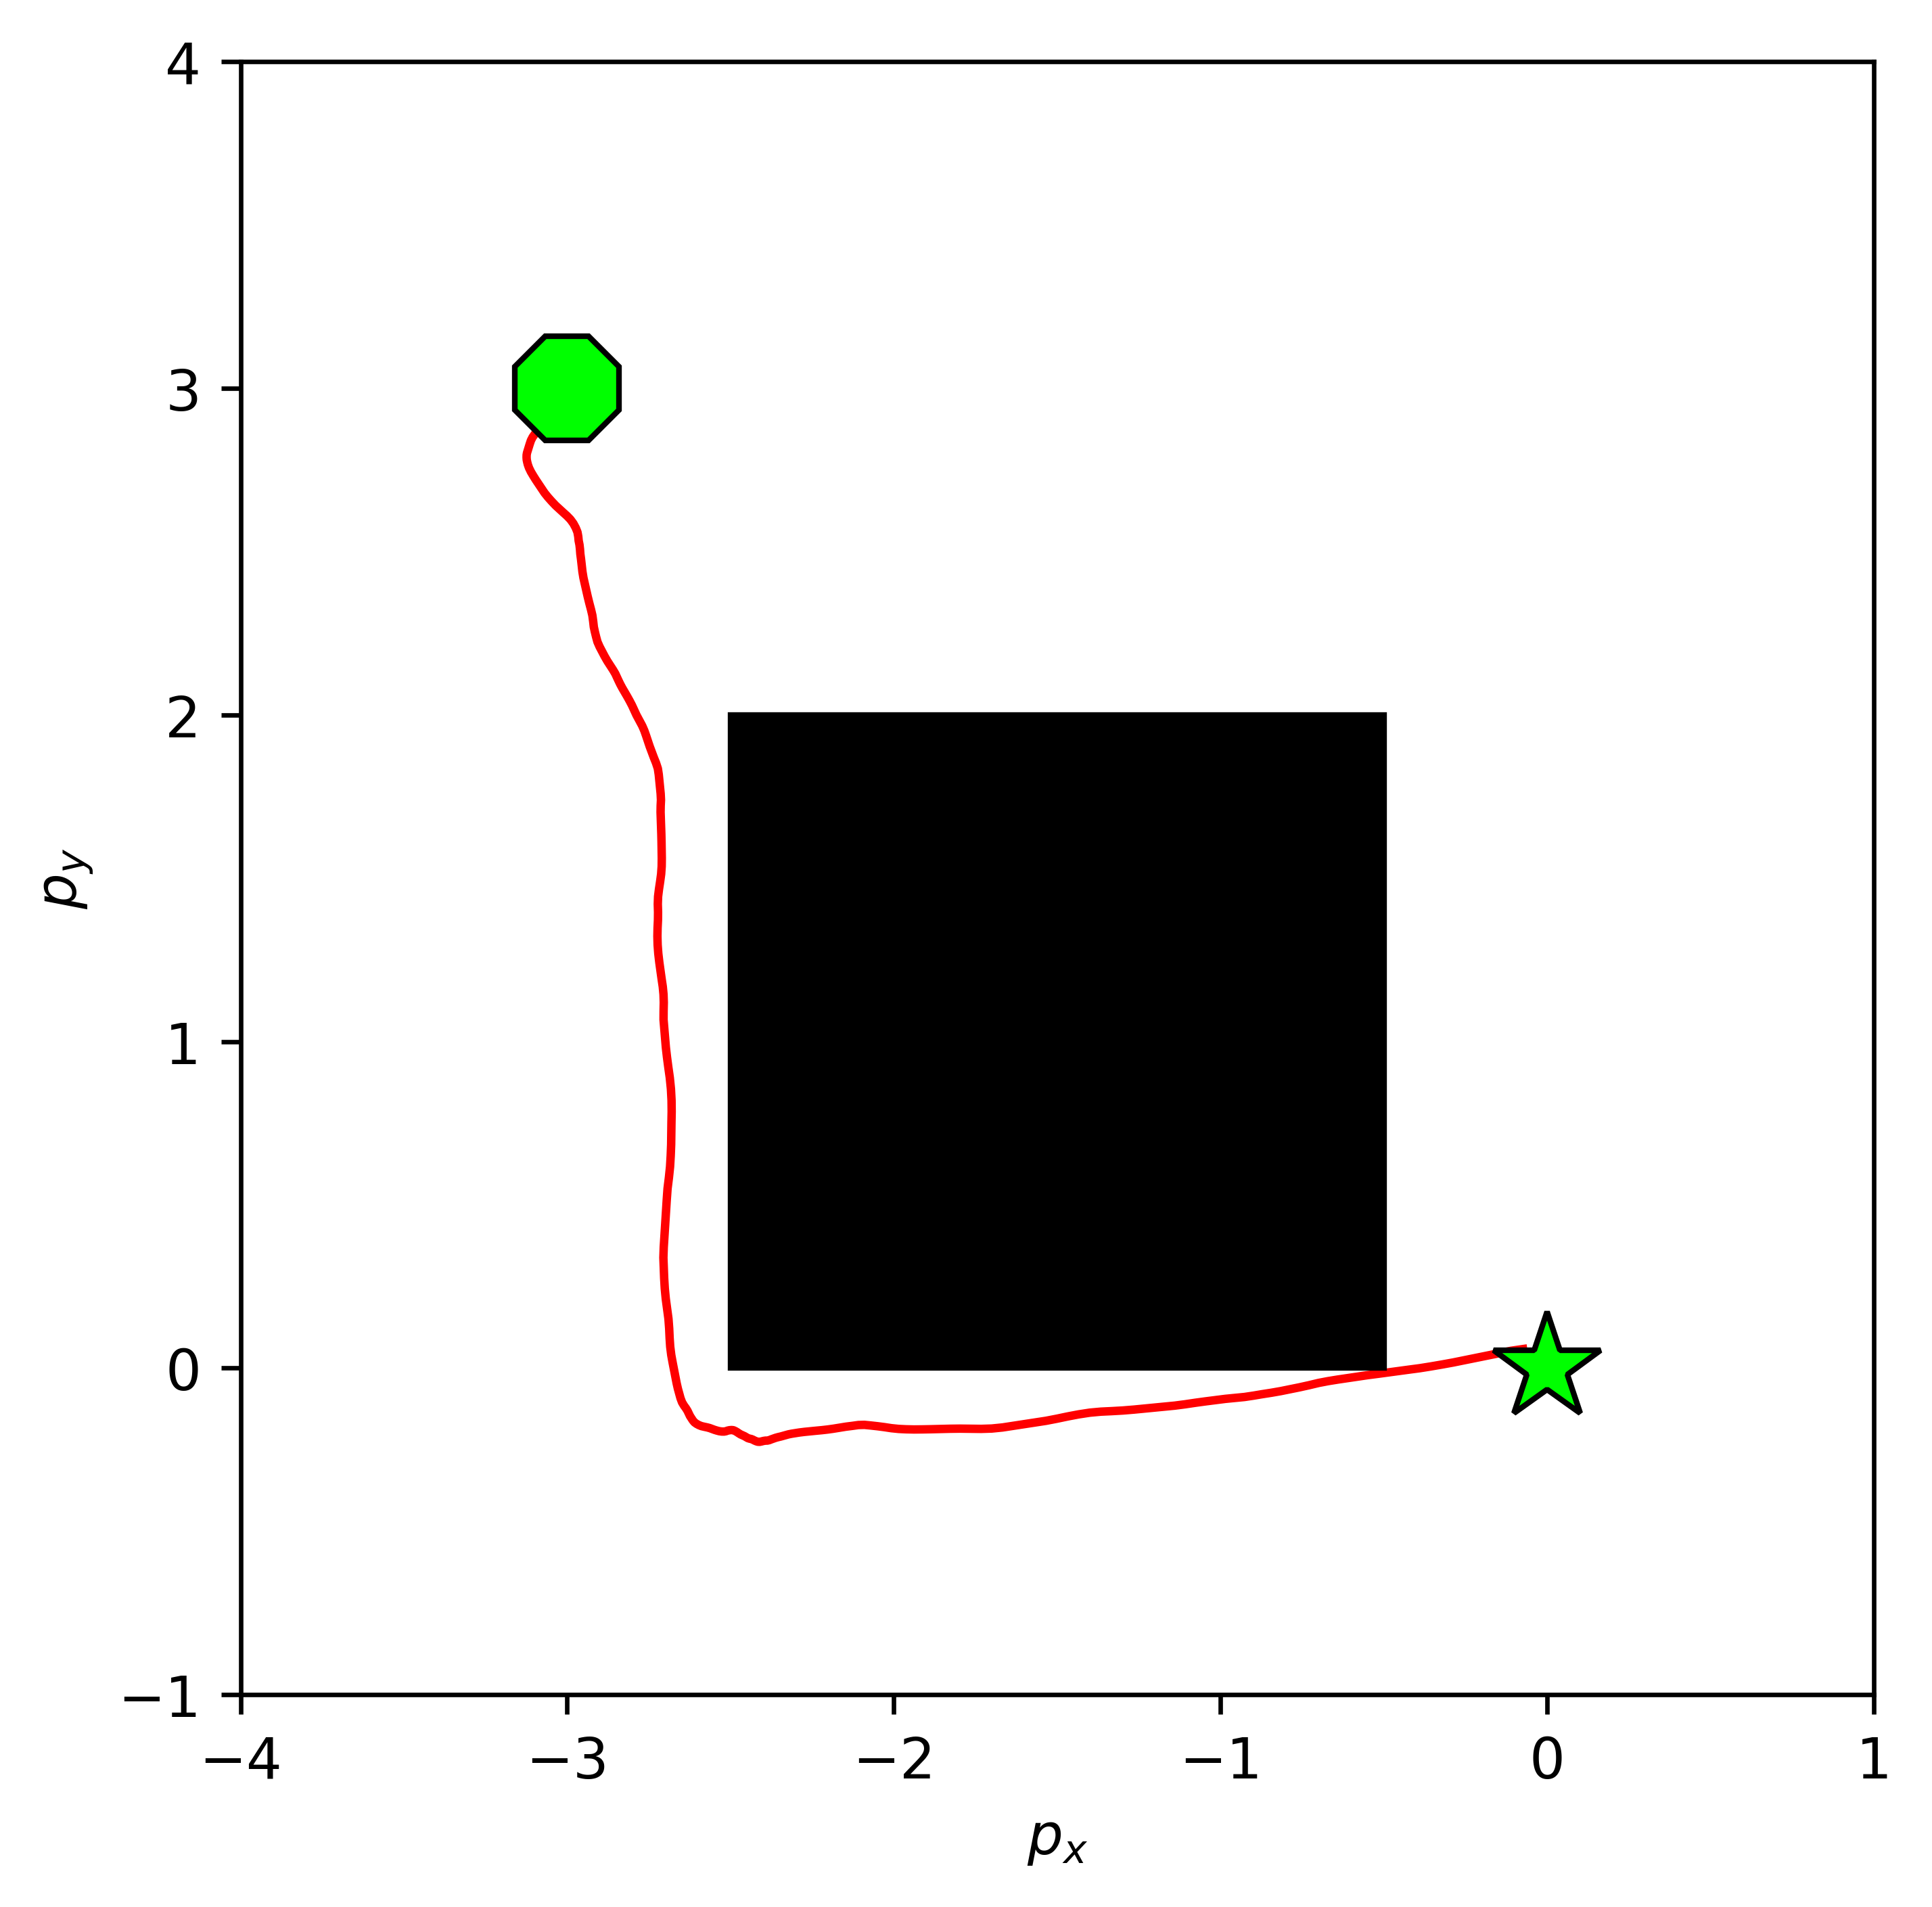

Goal reached at t=39.900000000000006s


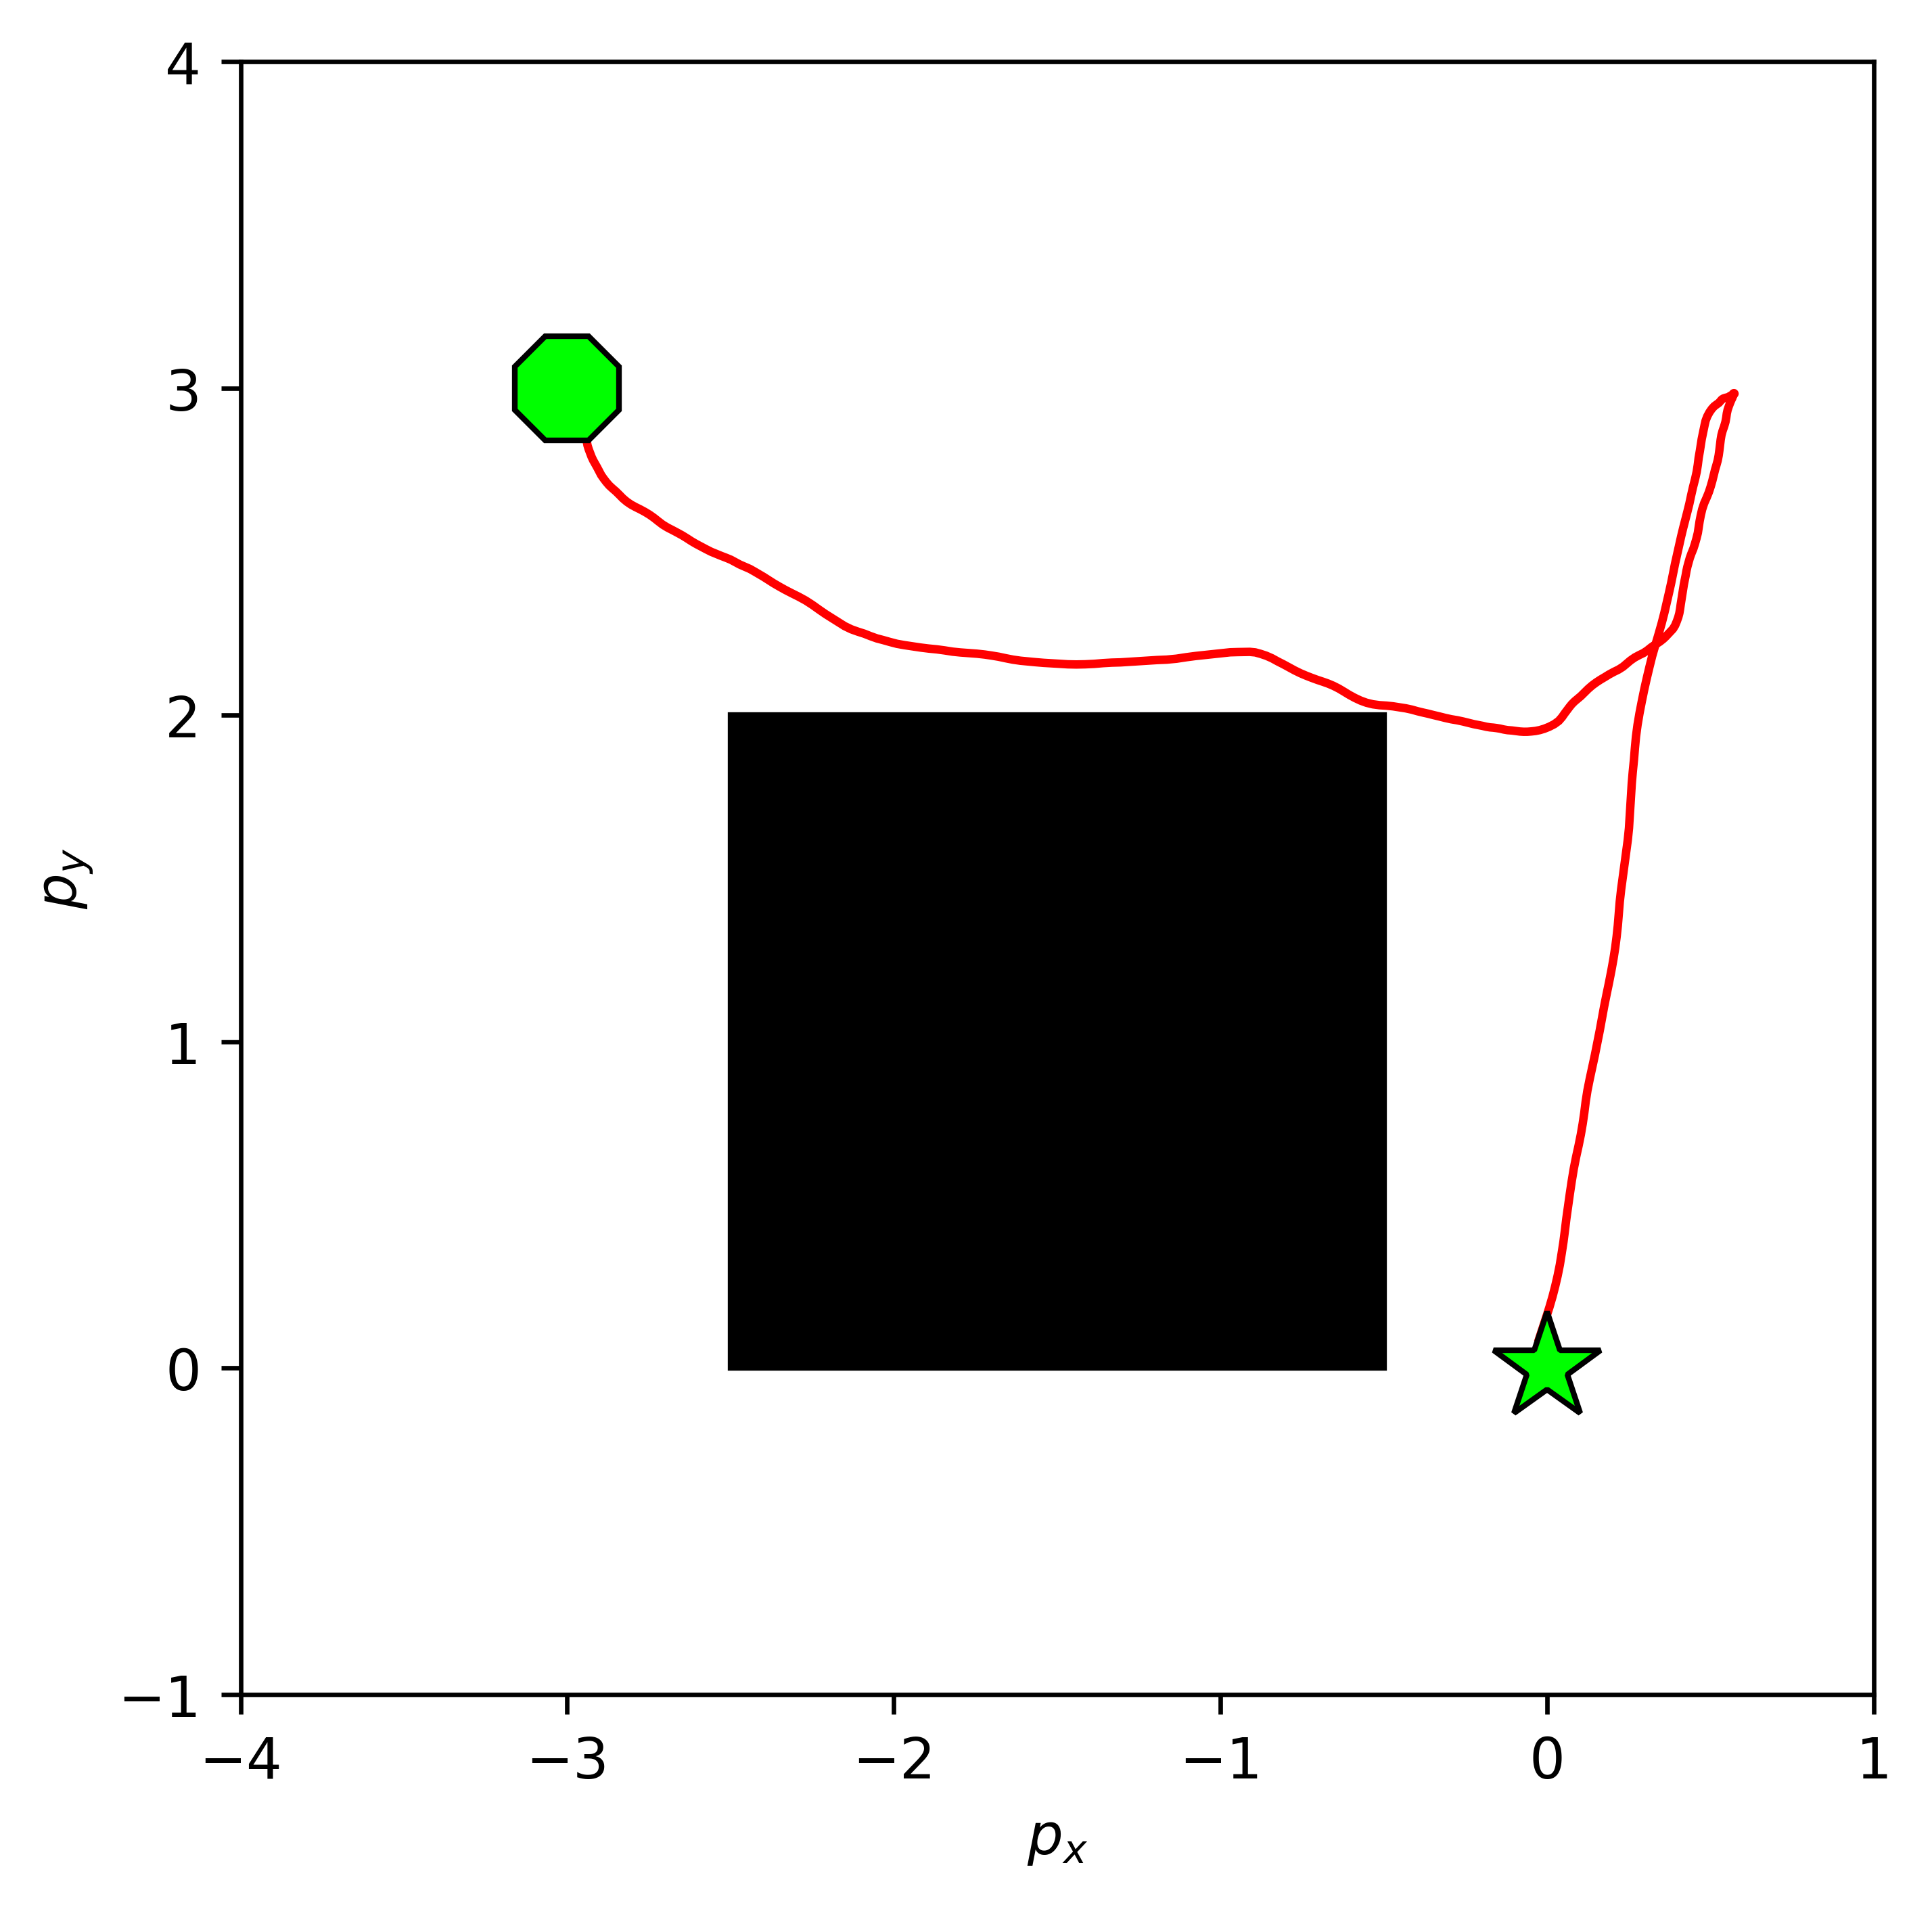

Goal reached at t=30.900000000000002s


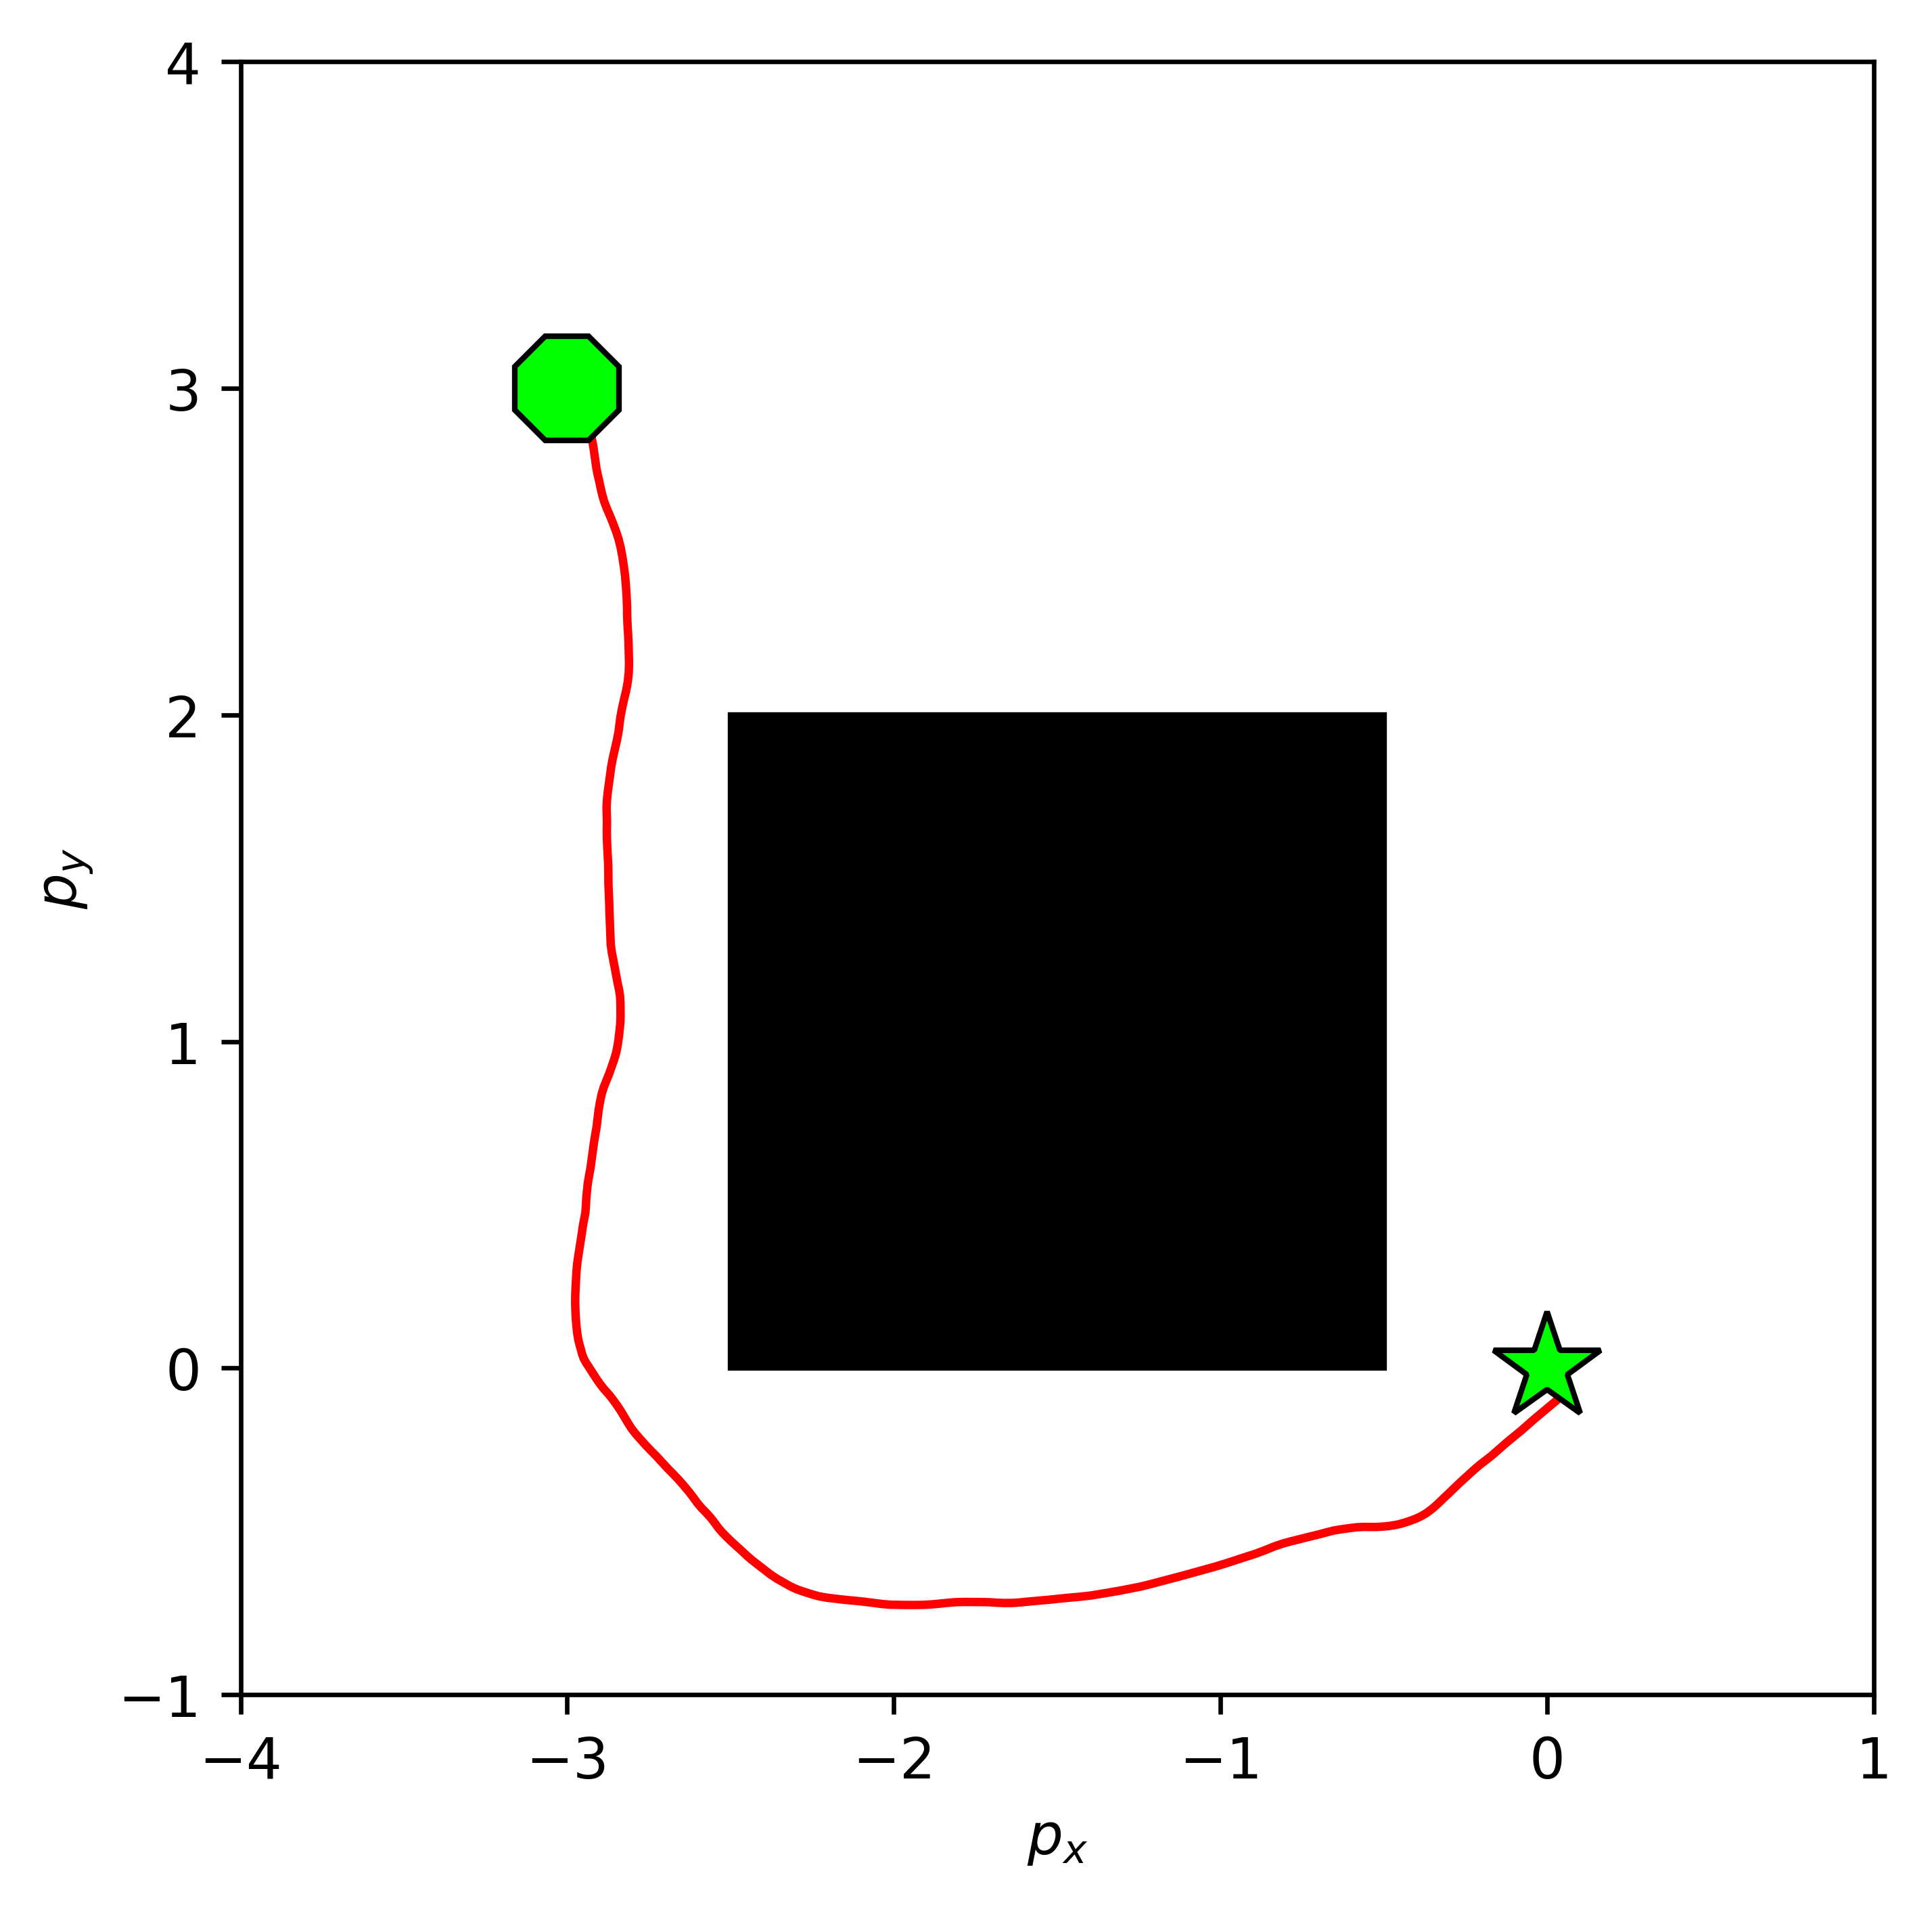

Hit boundary


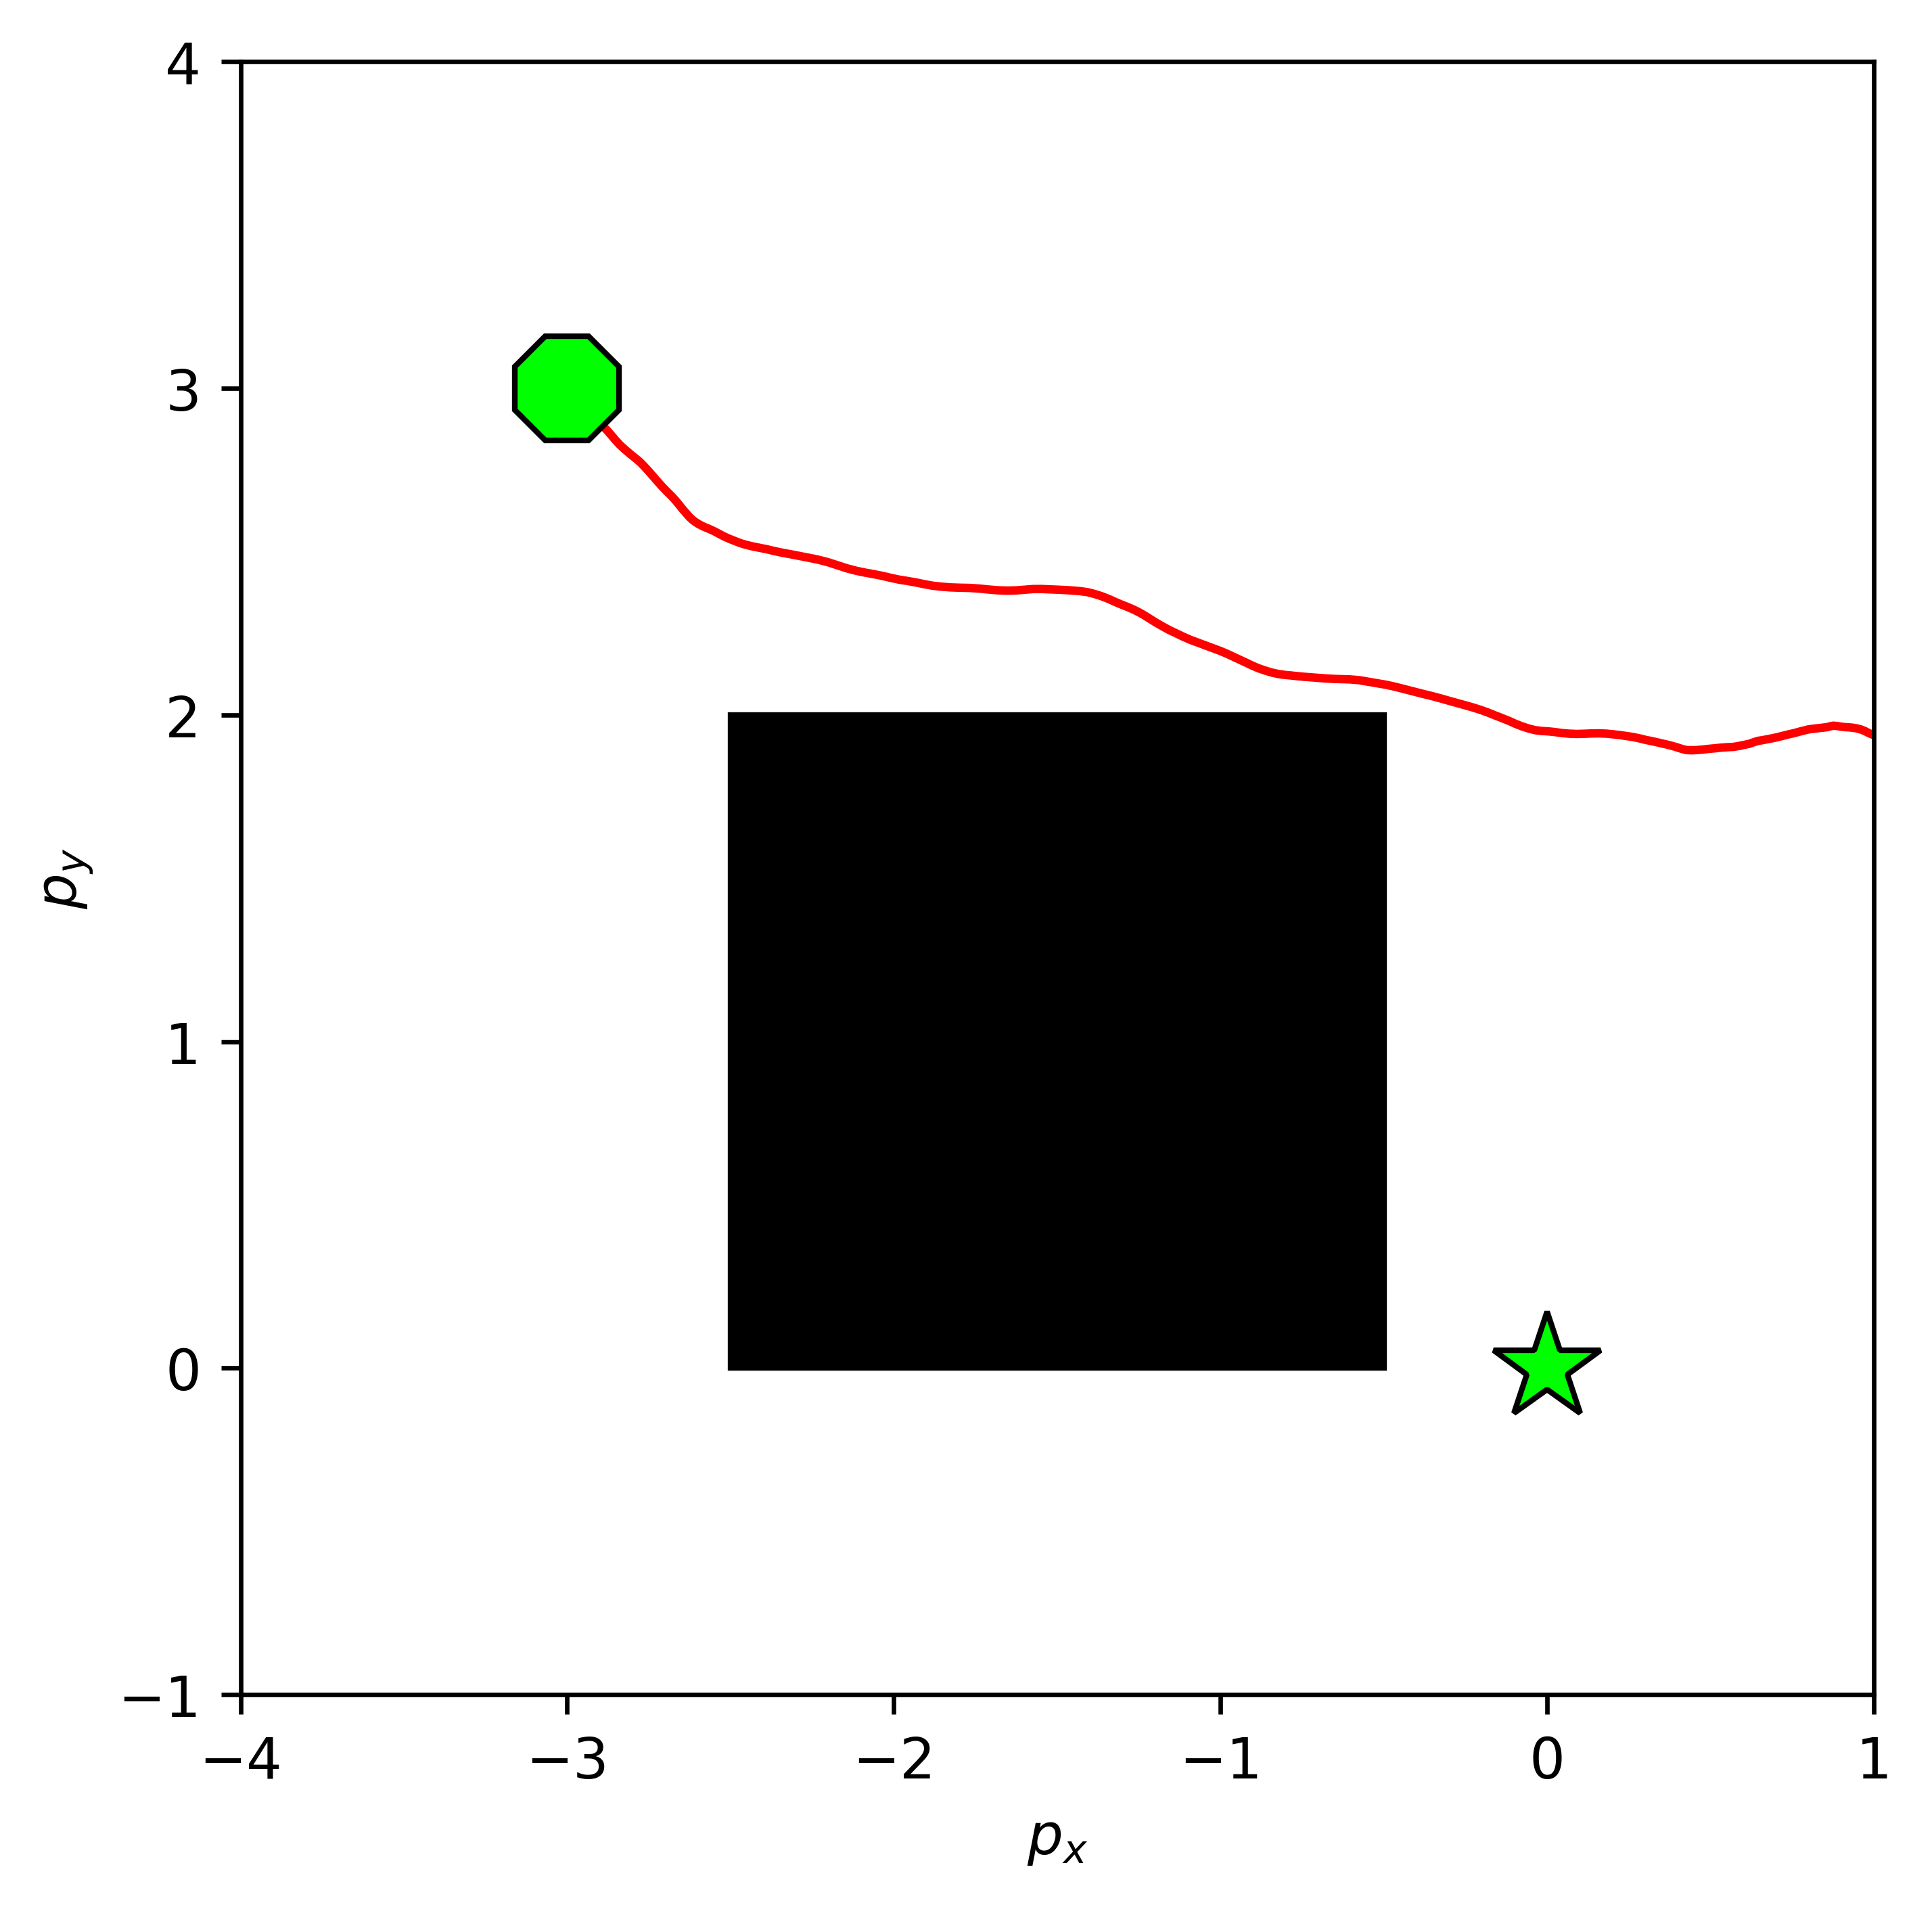

Goal reached at t=41.800000000000004s


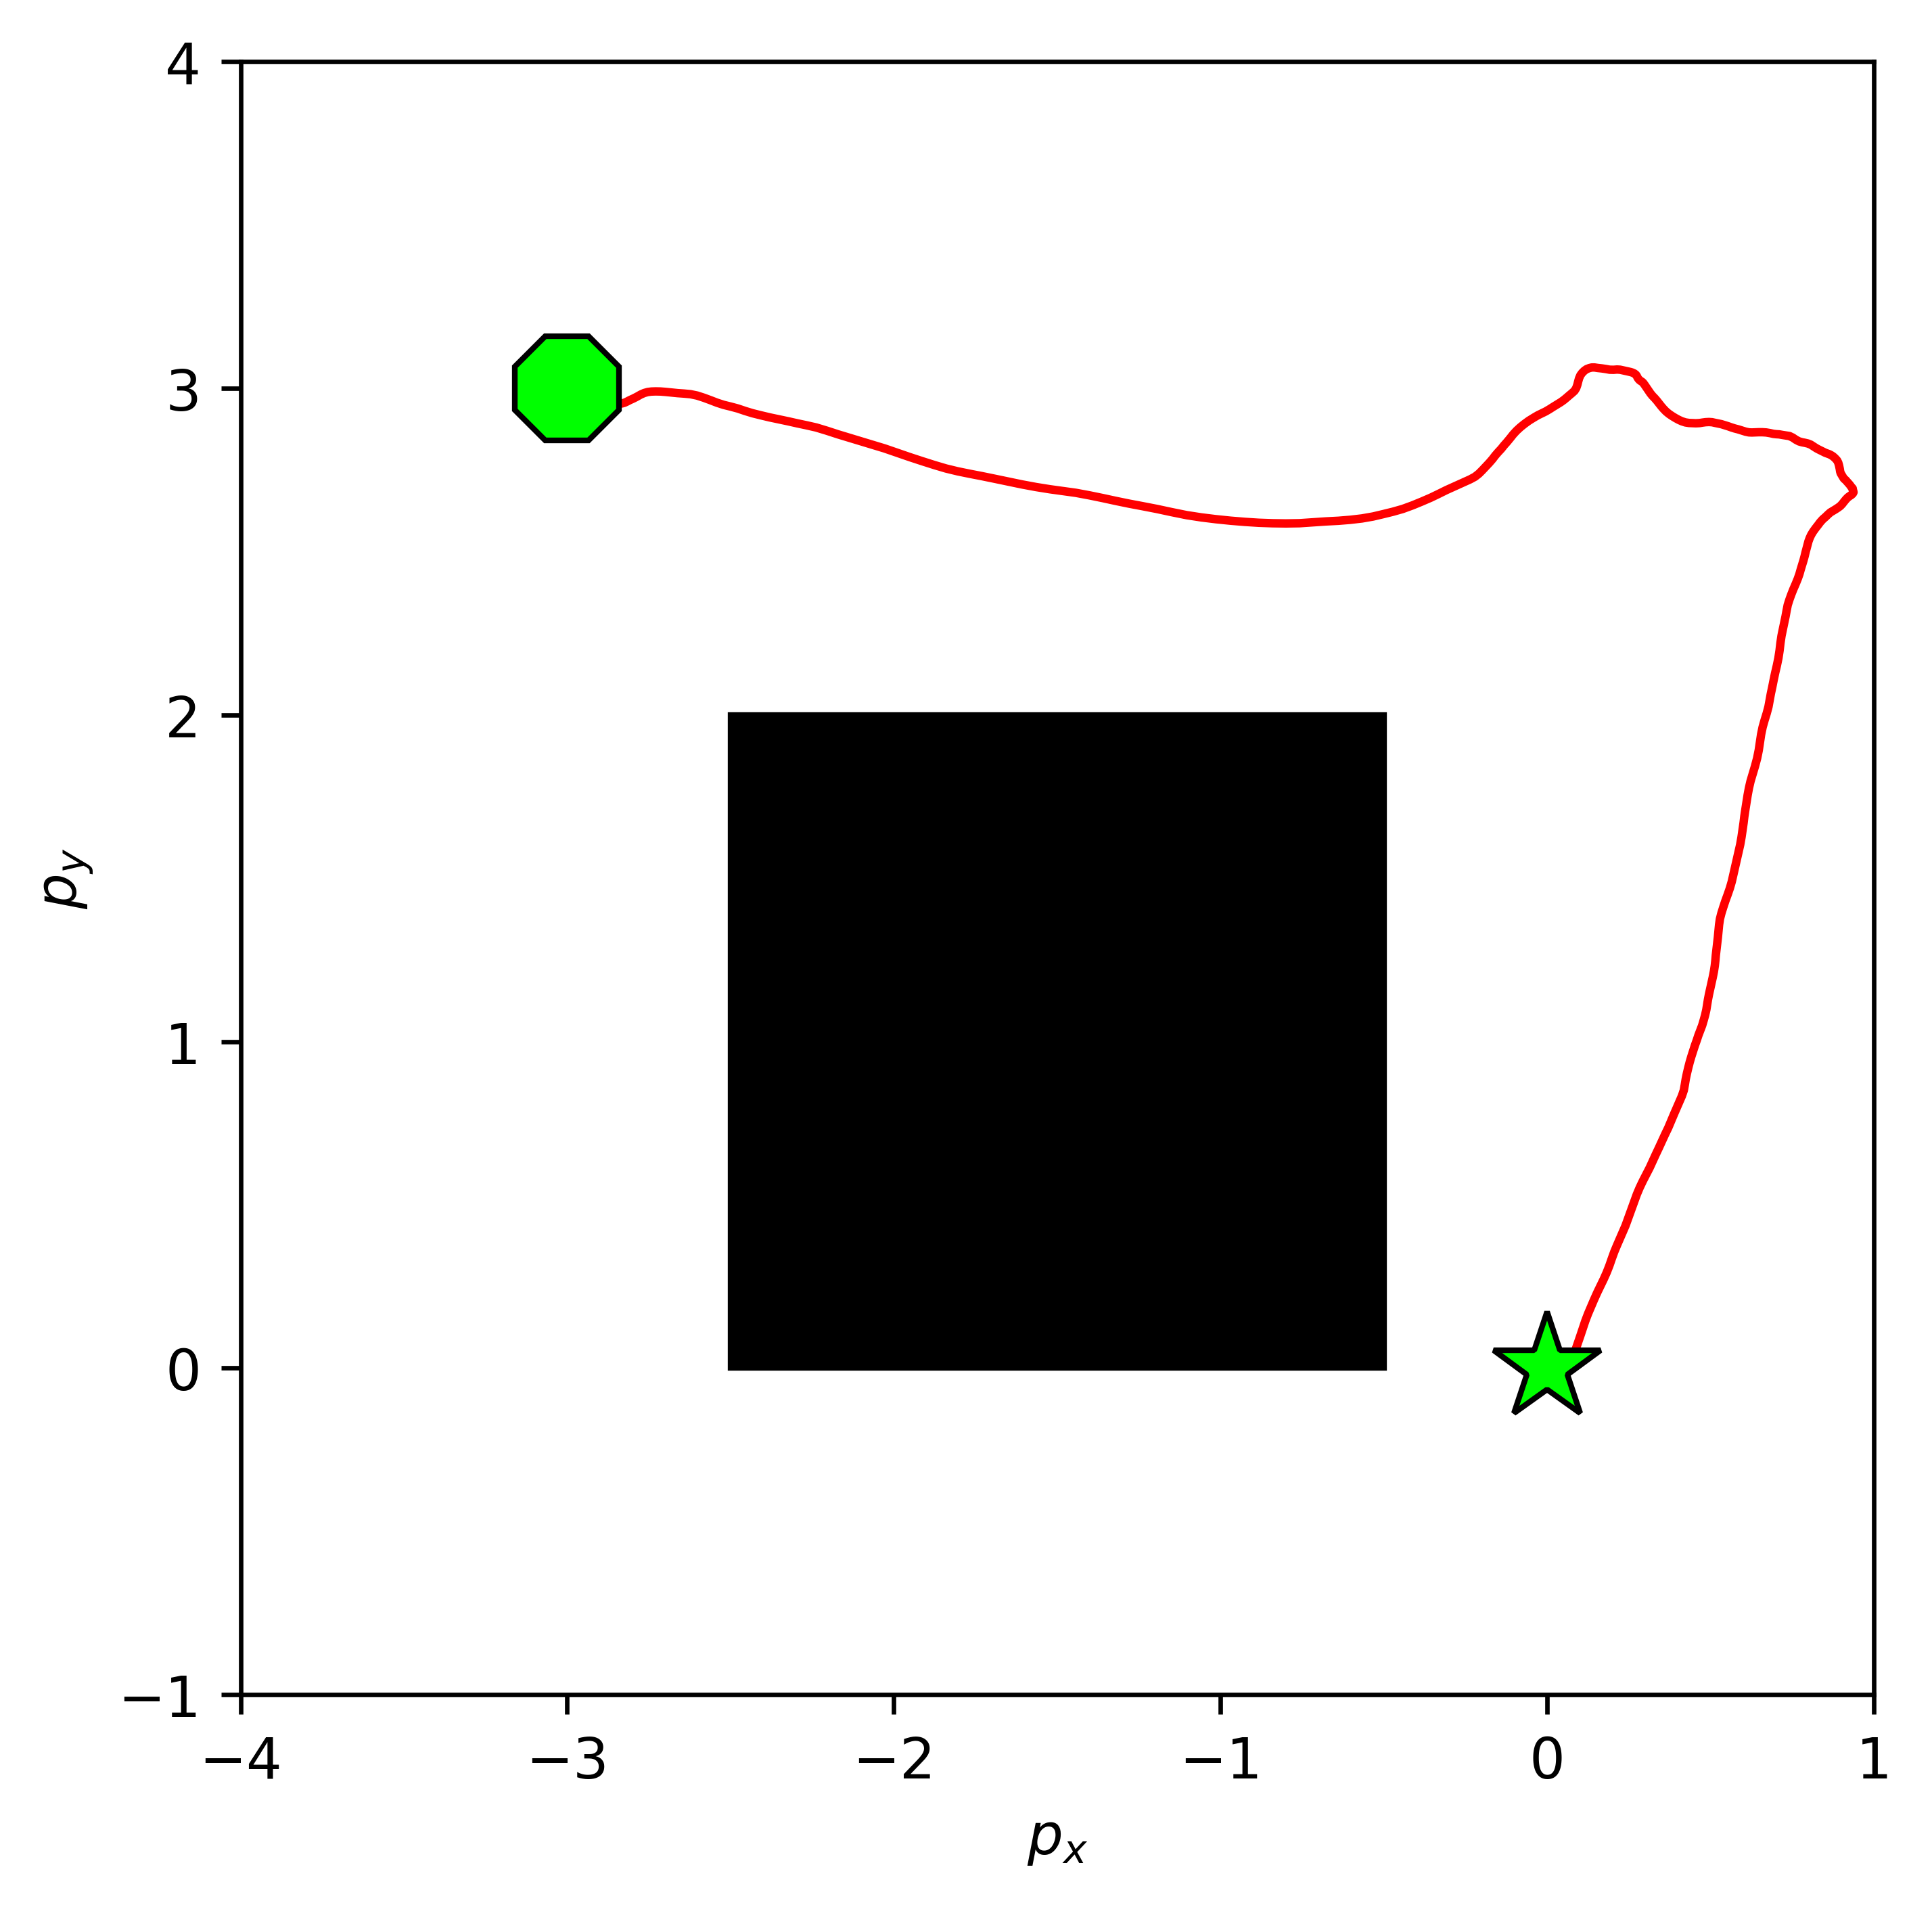

Hit obstacle


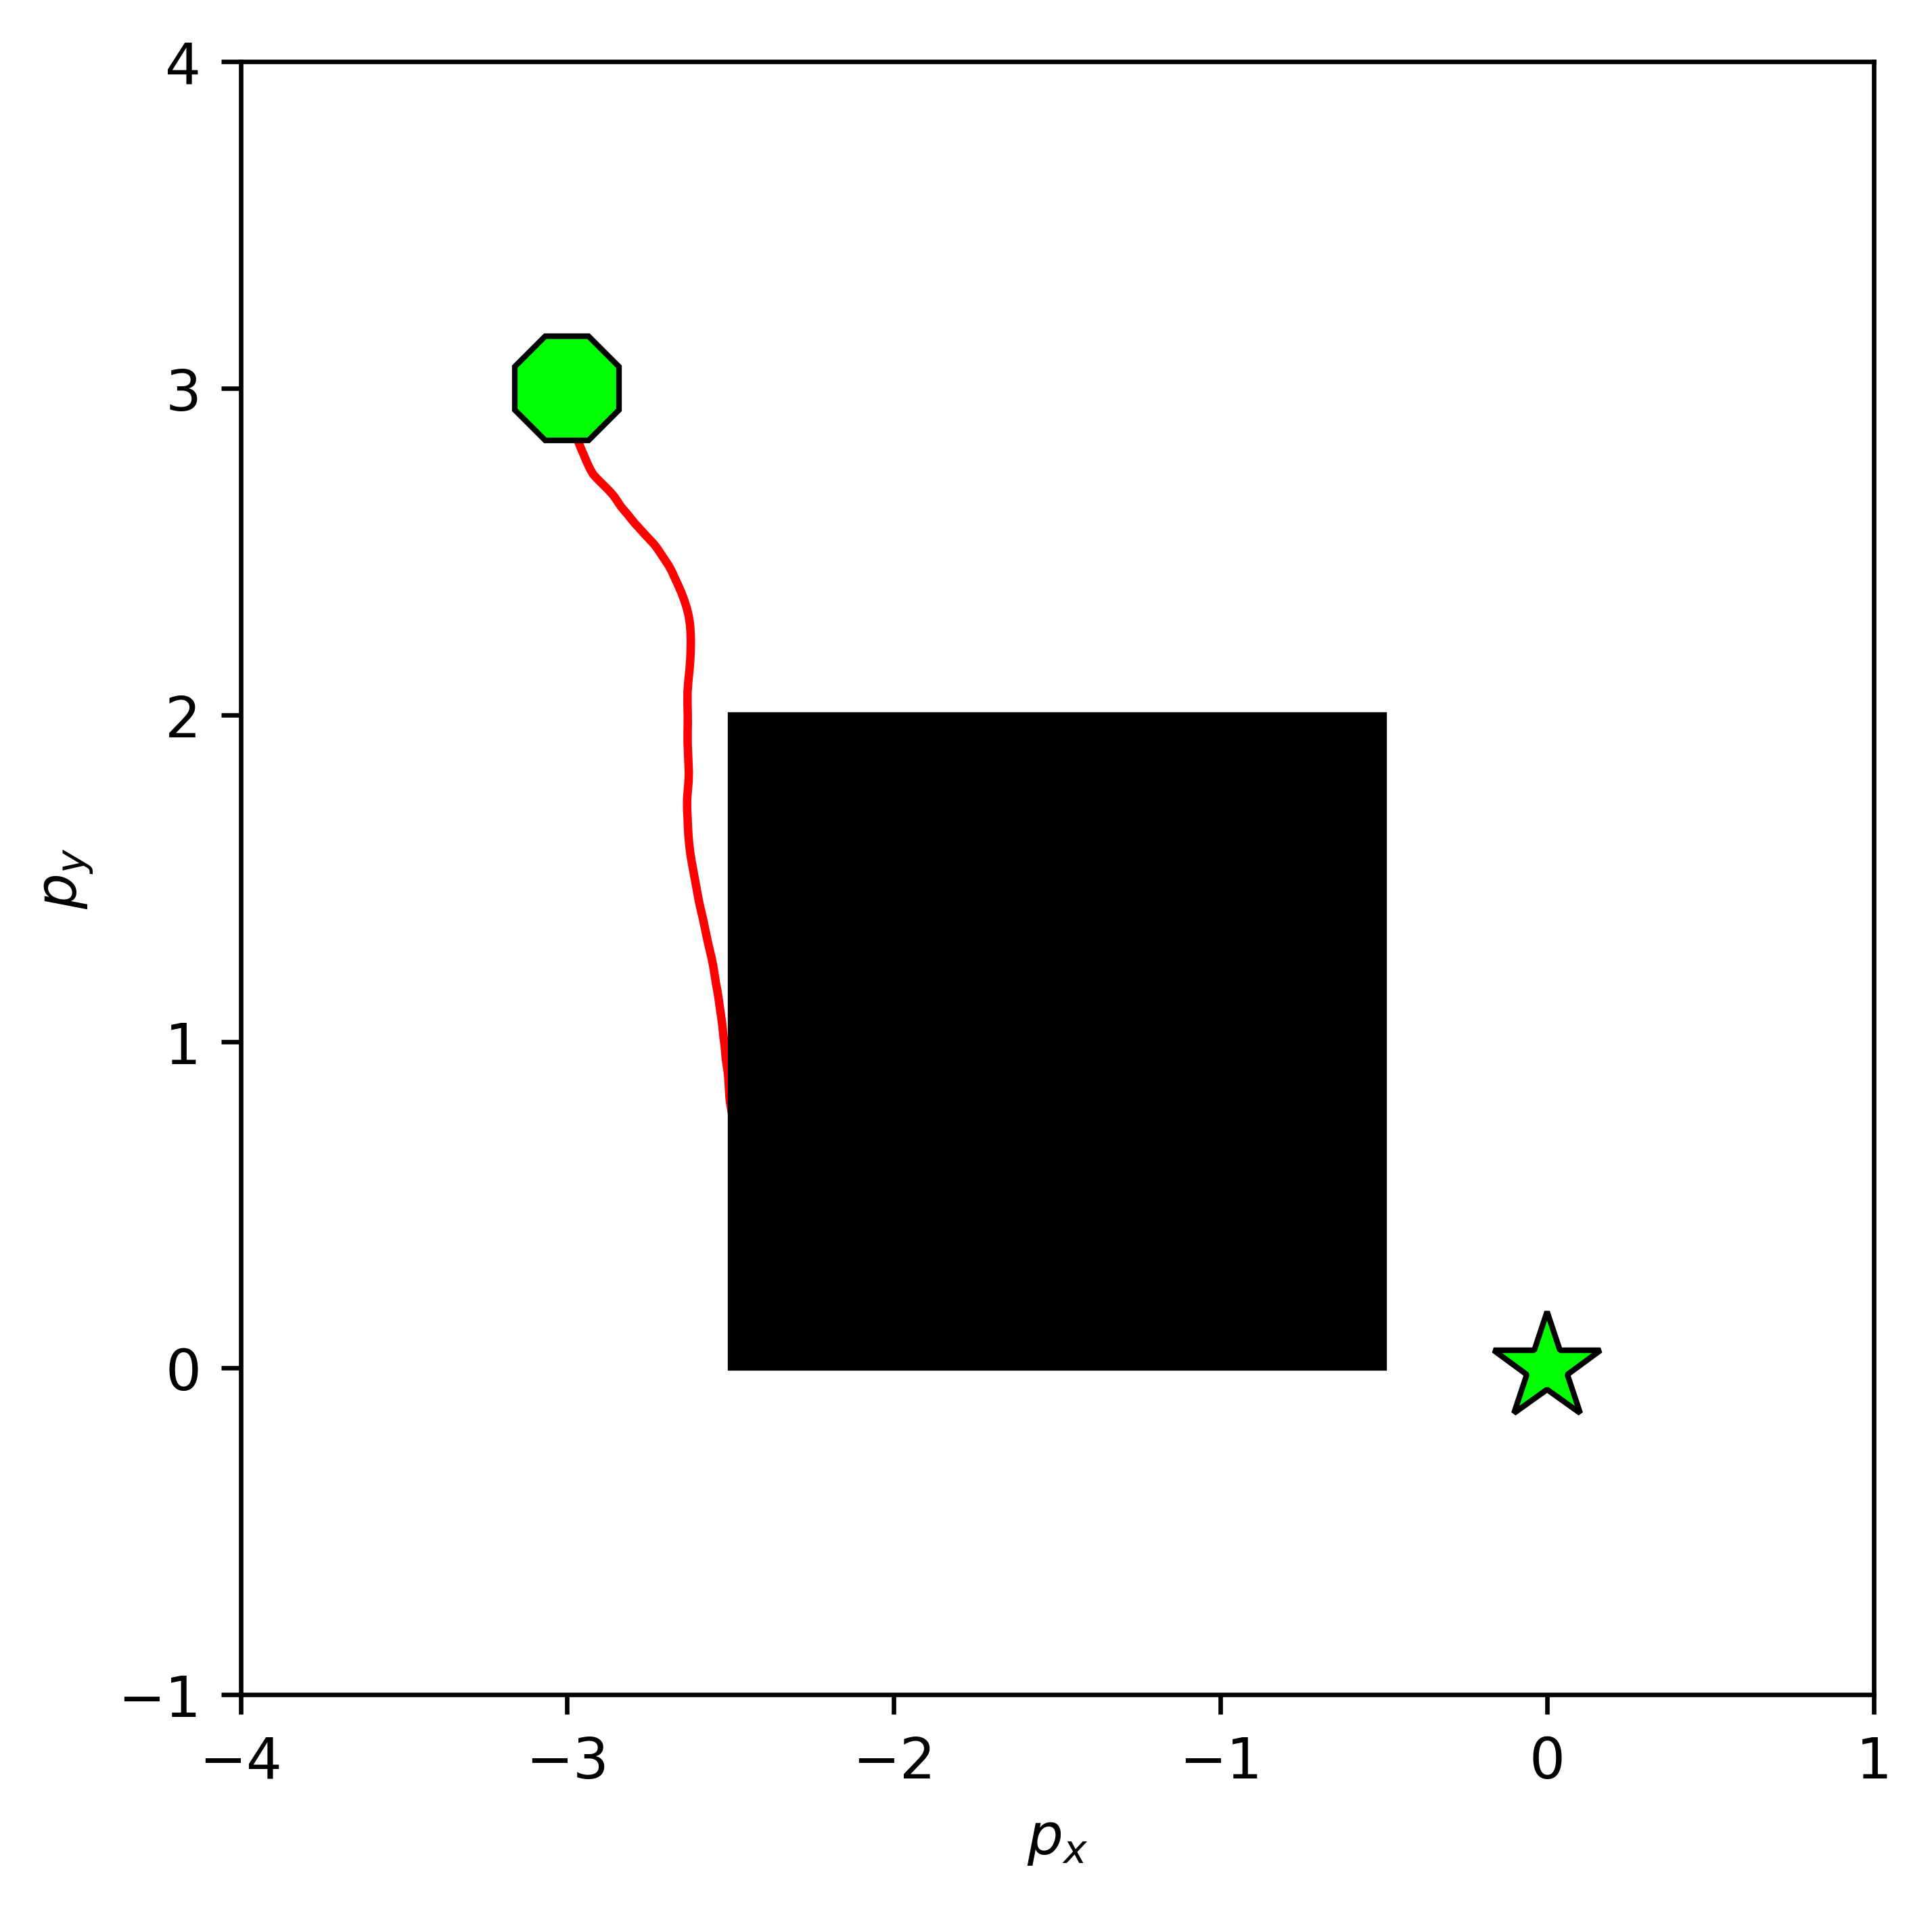

Goal reached at t=46.6s


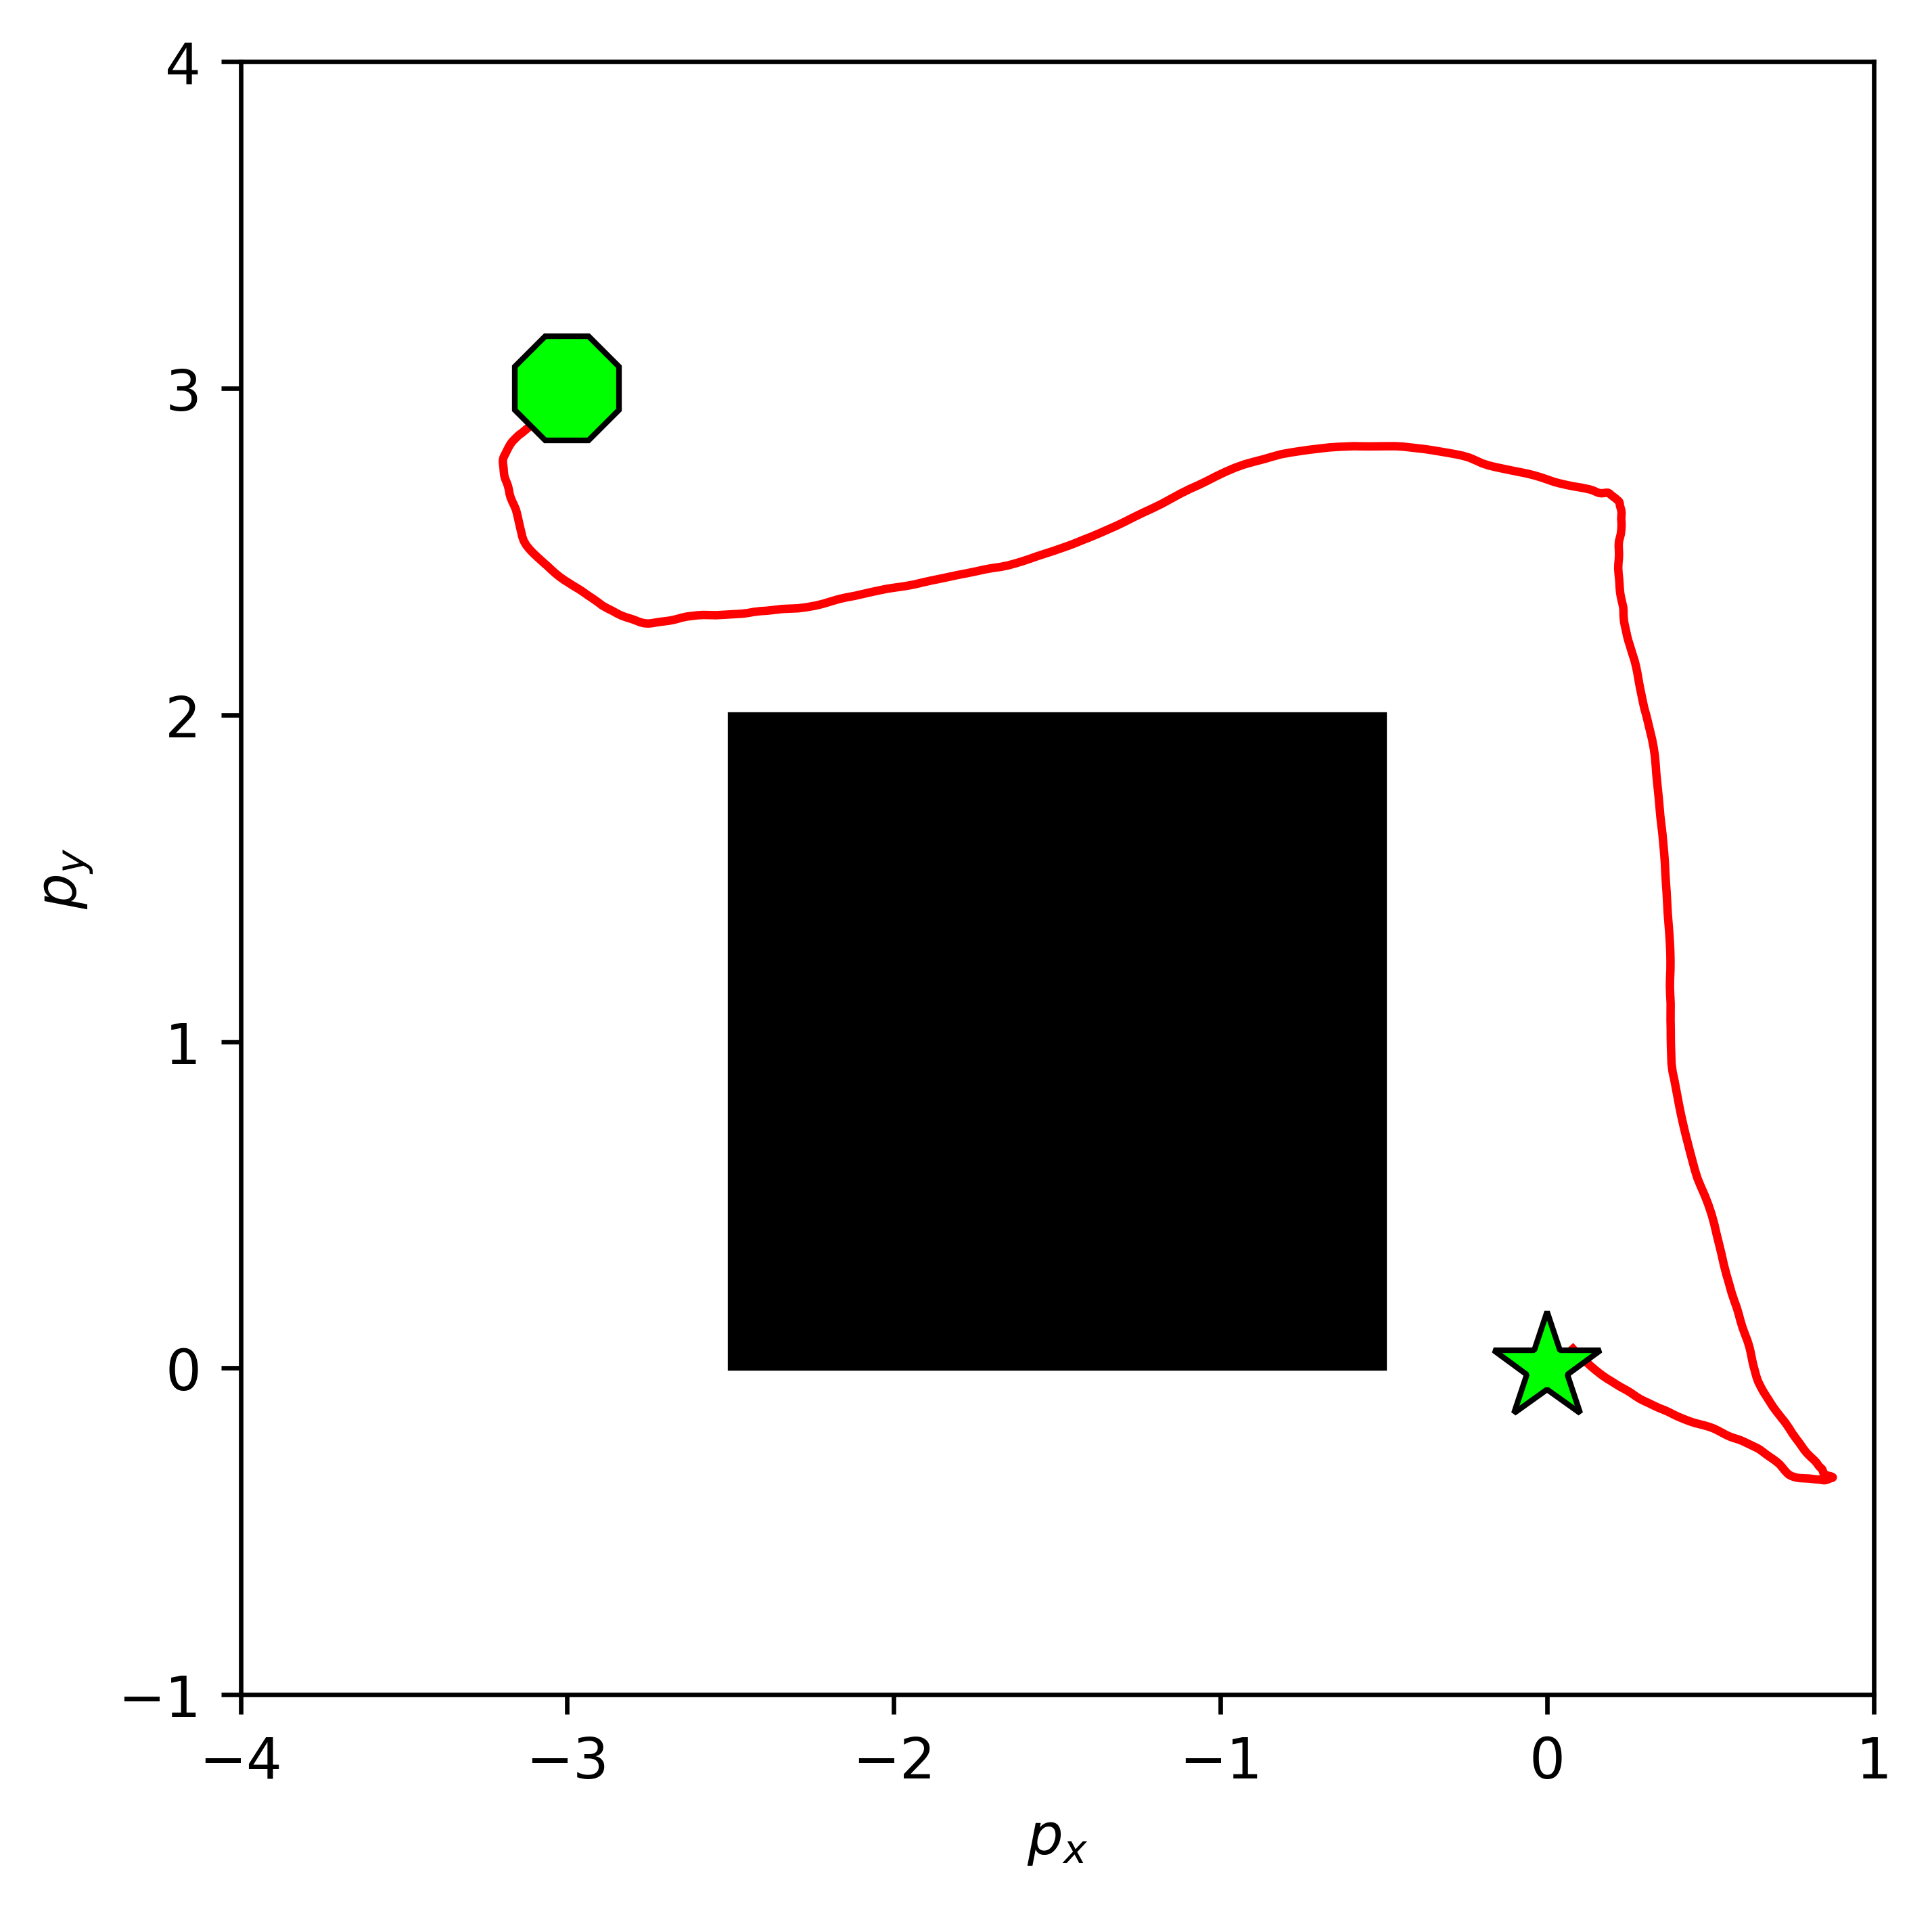

Hit obstacle


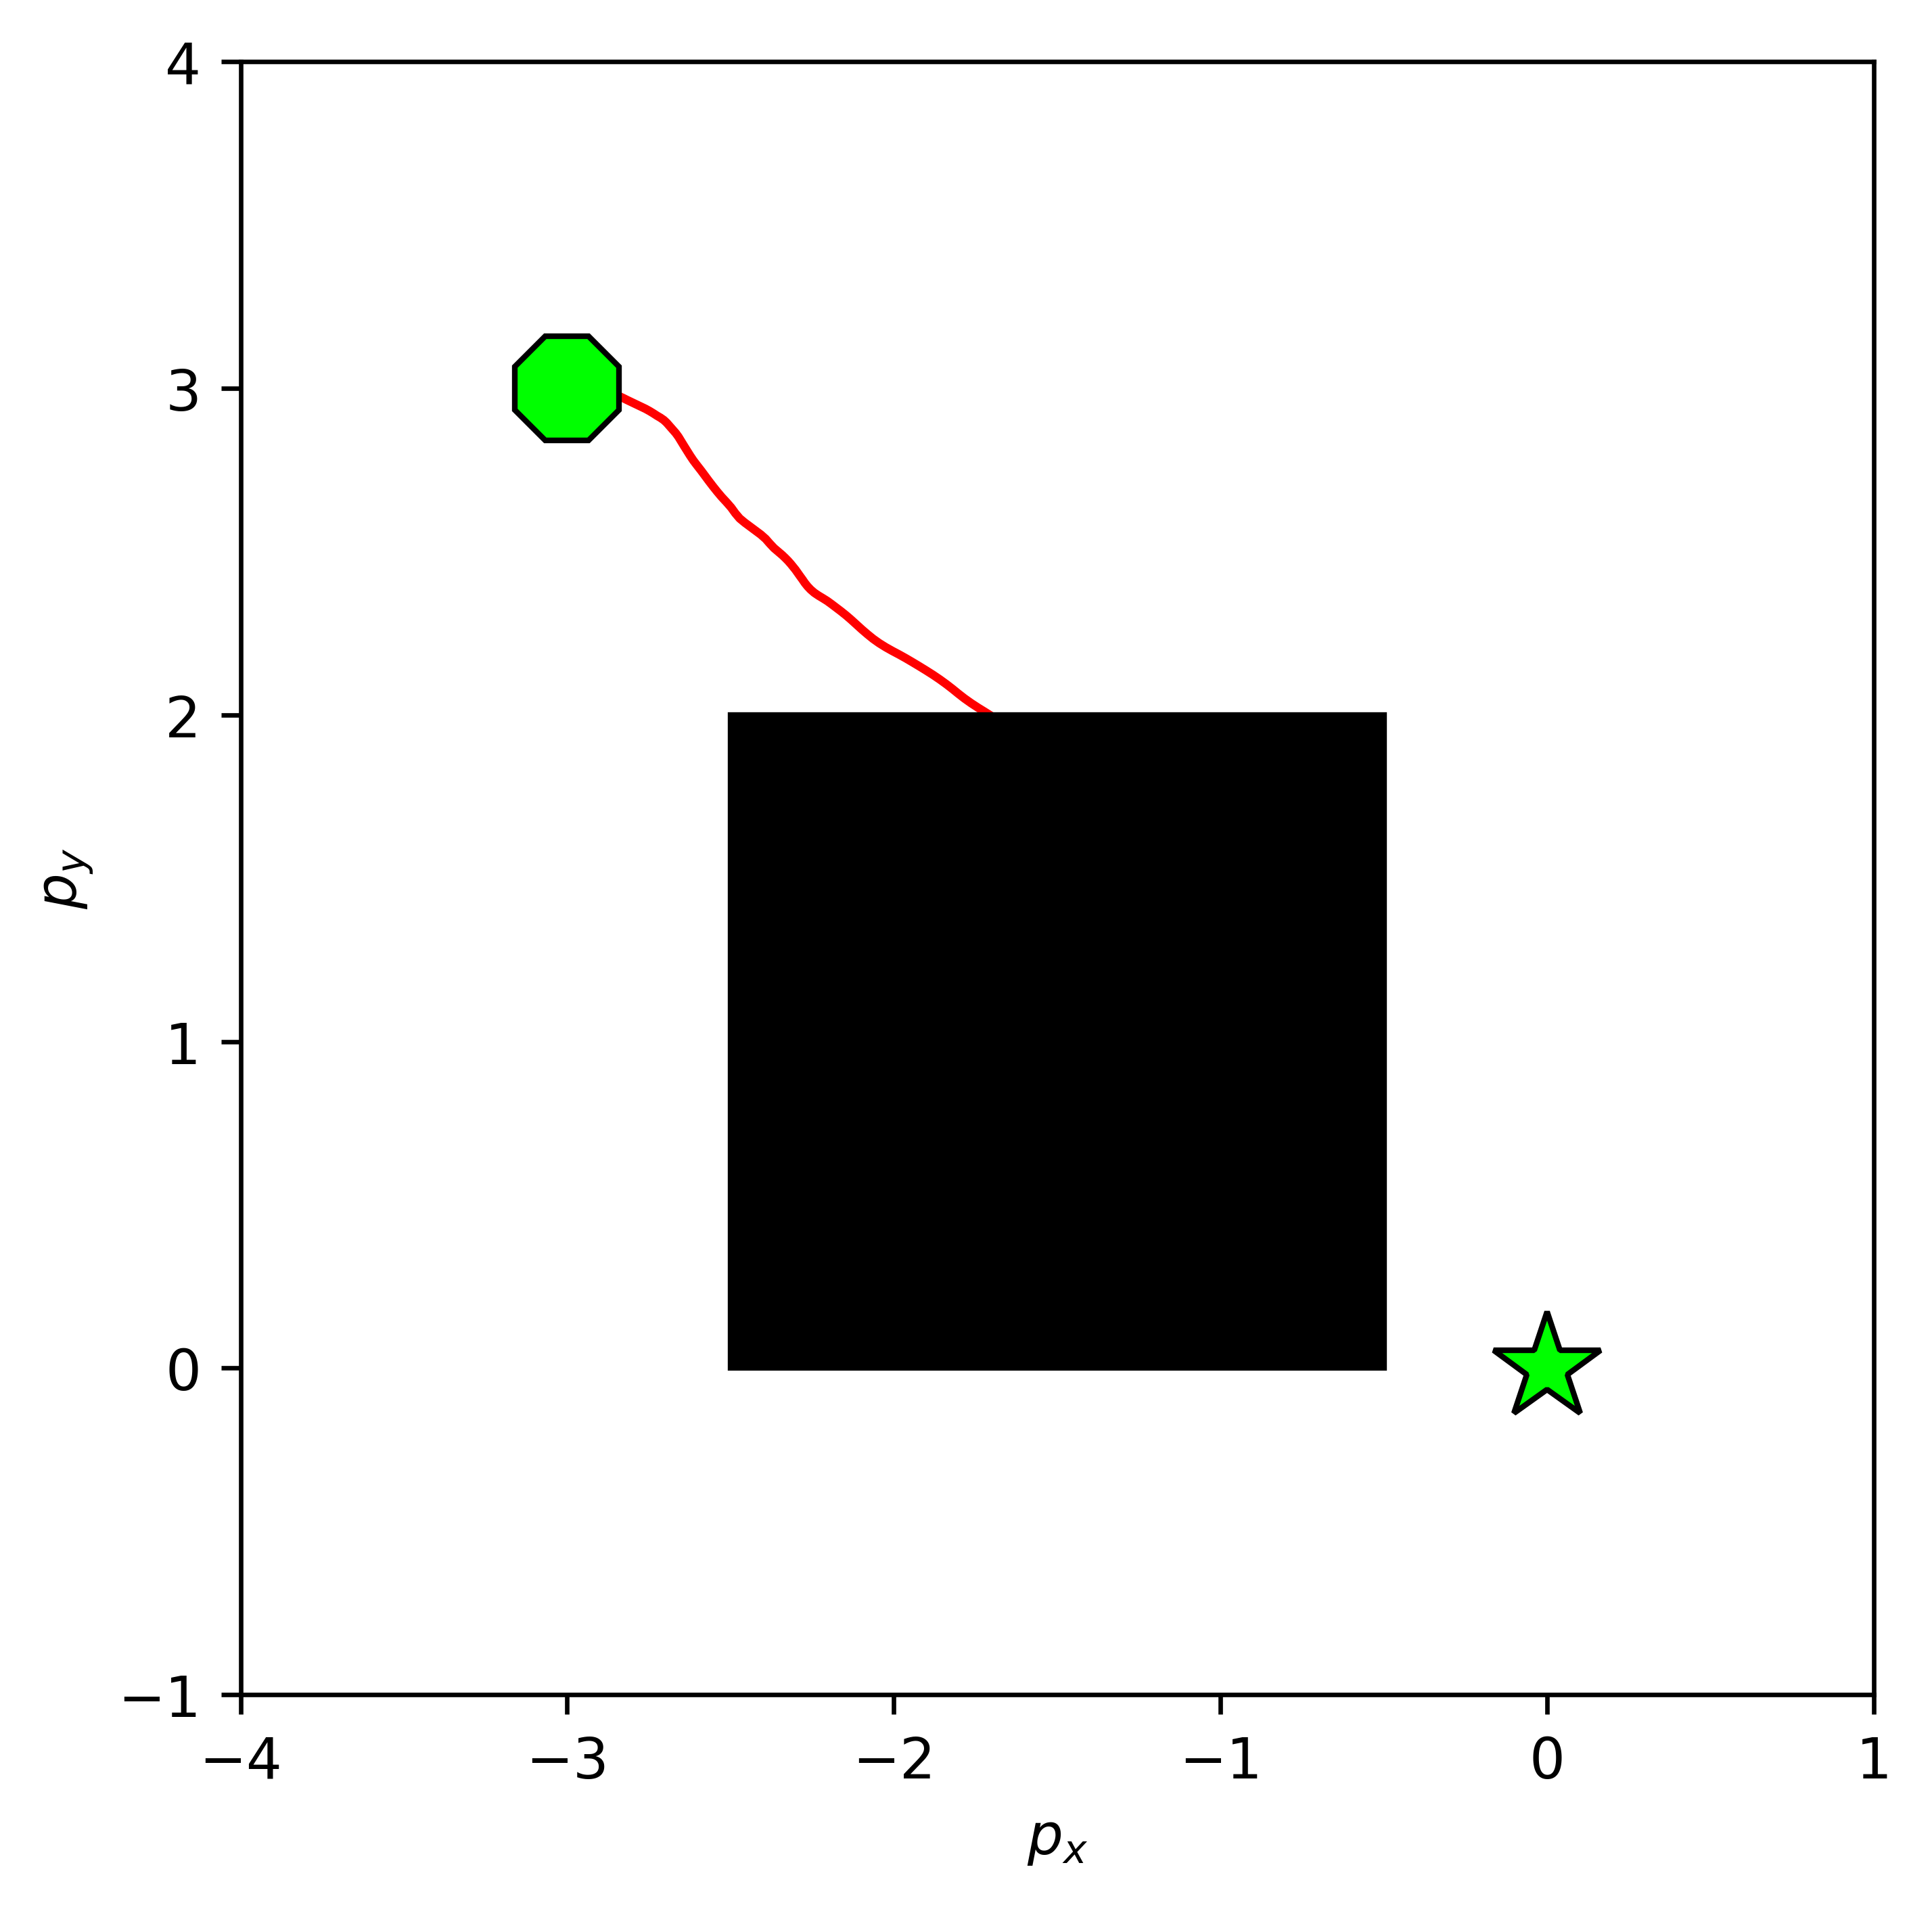

Hit obstacle


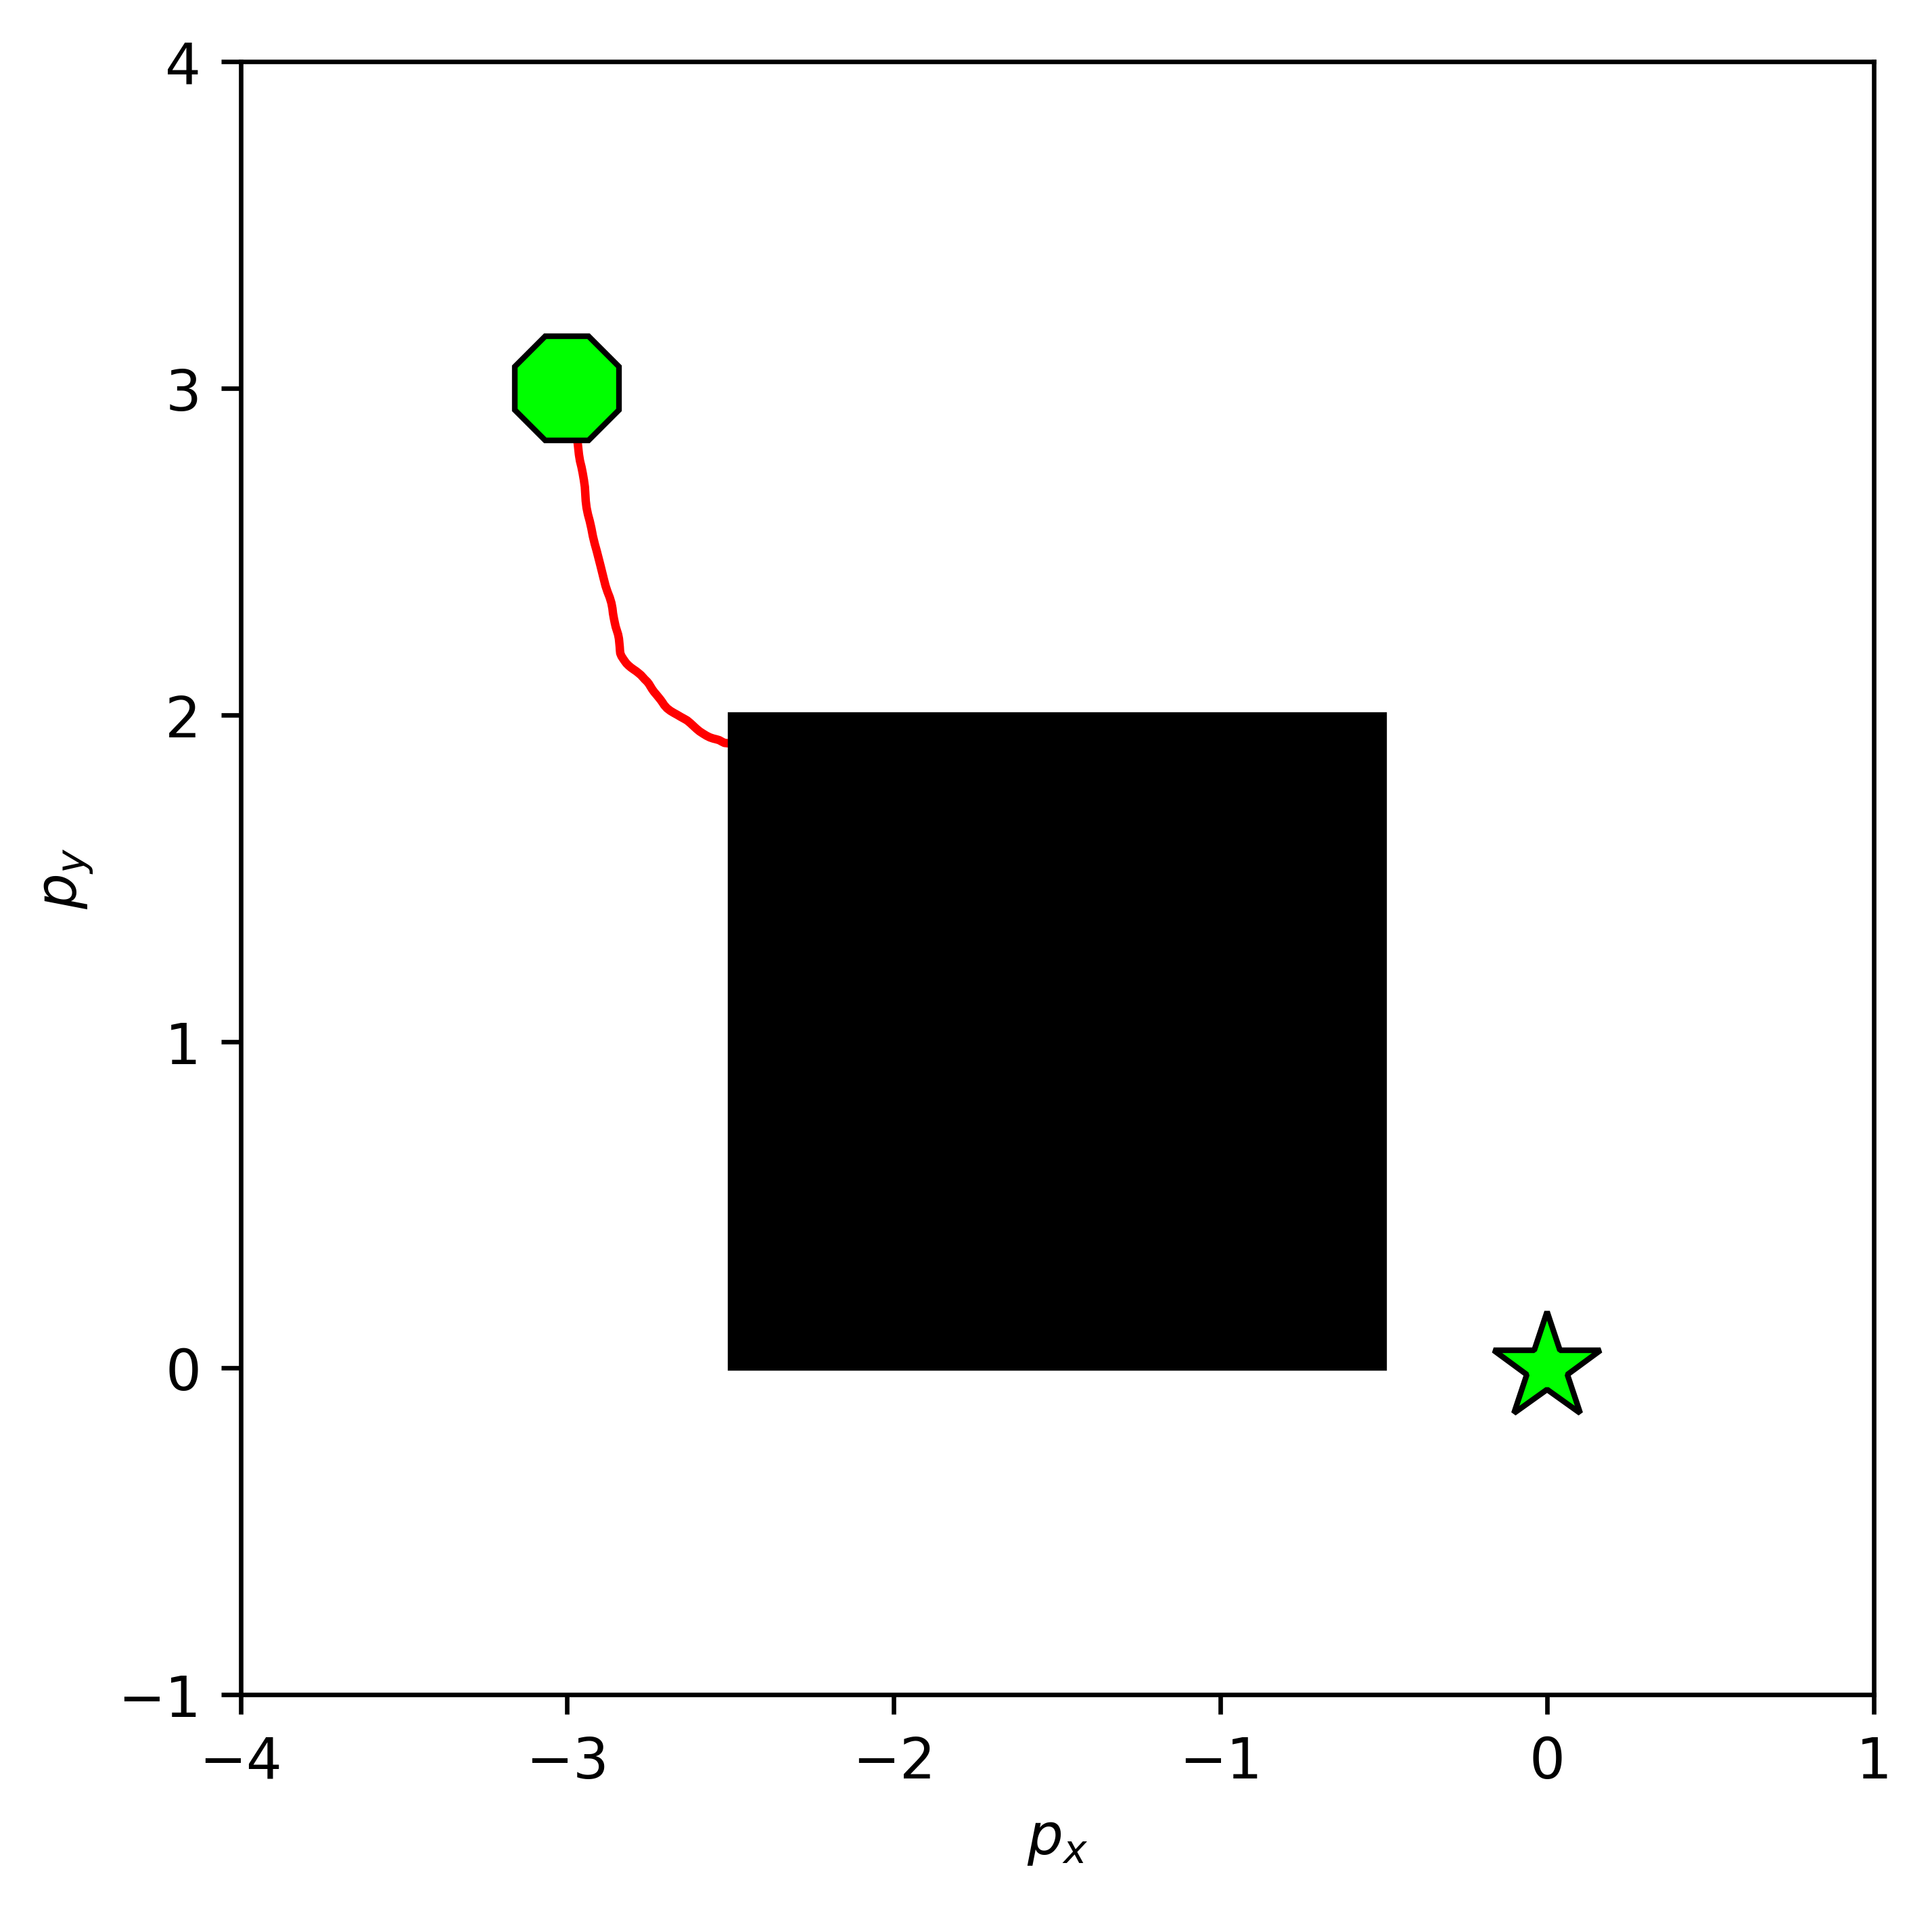

In [113]:
for k in range(num_simulation):
    
    terminate = False
    hit_obstacle = False
    hit_boundary = False

    # Simulation
    u_curr = np.zeros((int(T//dt), 2))
    x_hist = np.zeros((max_steps+1, 4)) * np.nan
    u_hist = np.zeros((max_steps+1, 2)) * np.nan
    x_hist[0] = x_init.copy()

    for t in range(max_steps):
        
        u_curr, x_vis = path_integral(dynamics, obstacles, Sigma, x_hist[t], x_goal, u_curr, dist_weight, 
                            obs_cost, obstacle_positions, obstacle_radius, 
                            T, dt, theta, num_trajs, init_report=t, gammas=gamma, method=method) 
        u_hist[t] = u_curr[0]

        noise = true_mu + np.random.multivariate_normal(np.zeros(u_curr.shape[1]), Sigma) # drift term + increment of a standard Wiener process

        # x_hist[t+1] = F @ x_hist[t] + G @ (u_curr[0] + noise) Set G == the noise Mapping Matrix    
        x_hist[t+1] = dynamics.compute_next_state(x_hist[t], u_curr[0], noise)

        hit_obstacle = obstacles.check_hit_obstacle(x_hist[t+1])
        if hit_obstacle:
            terminate = True
            fail_index.append(k)
            print("Hit obstacle")
            break
                
        hit_boundary = obstacles.check_hit_boundary(x_hist[t+1])
        if hit_boundary:
            terminate = True
            fail_index.append(k)
            print("Hit boundary")
            break
                
        # Goal check
        if  np.linalg.norm(x_hist[t+1, :2] - x_goal) <= goal_tolerance <= goal_tolerance:
            print(f"Goal reached at t={t * dt}s")
            success_time.append(t * dt)
            terminate = True
            success_index.append(k)
            break
    
    x_hists[k, :t, :] = x_hist[:t, :2]

    if terminate:
        fig, ax = plt.subplots()
        ax.plot([x_init[0]], [x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
        ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
        obstacles.plot_obstacles(ax)

        ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        ax.set_xlim(obstacles.boundary_x)
        ax.set_ylim(obstacles.boundary_y)
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

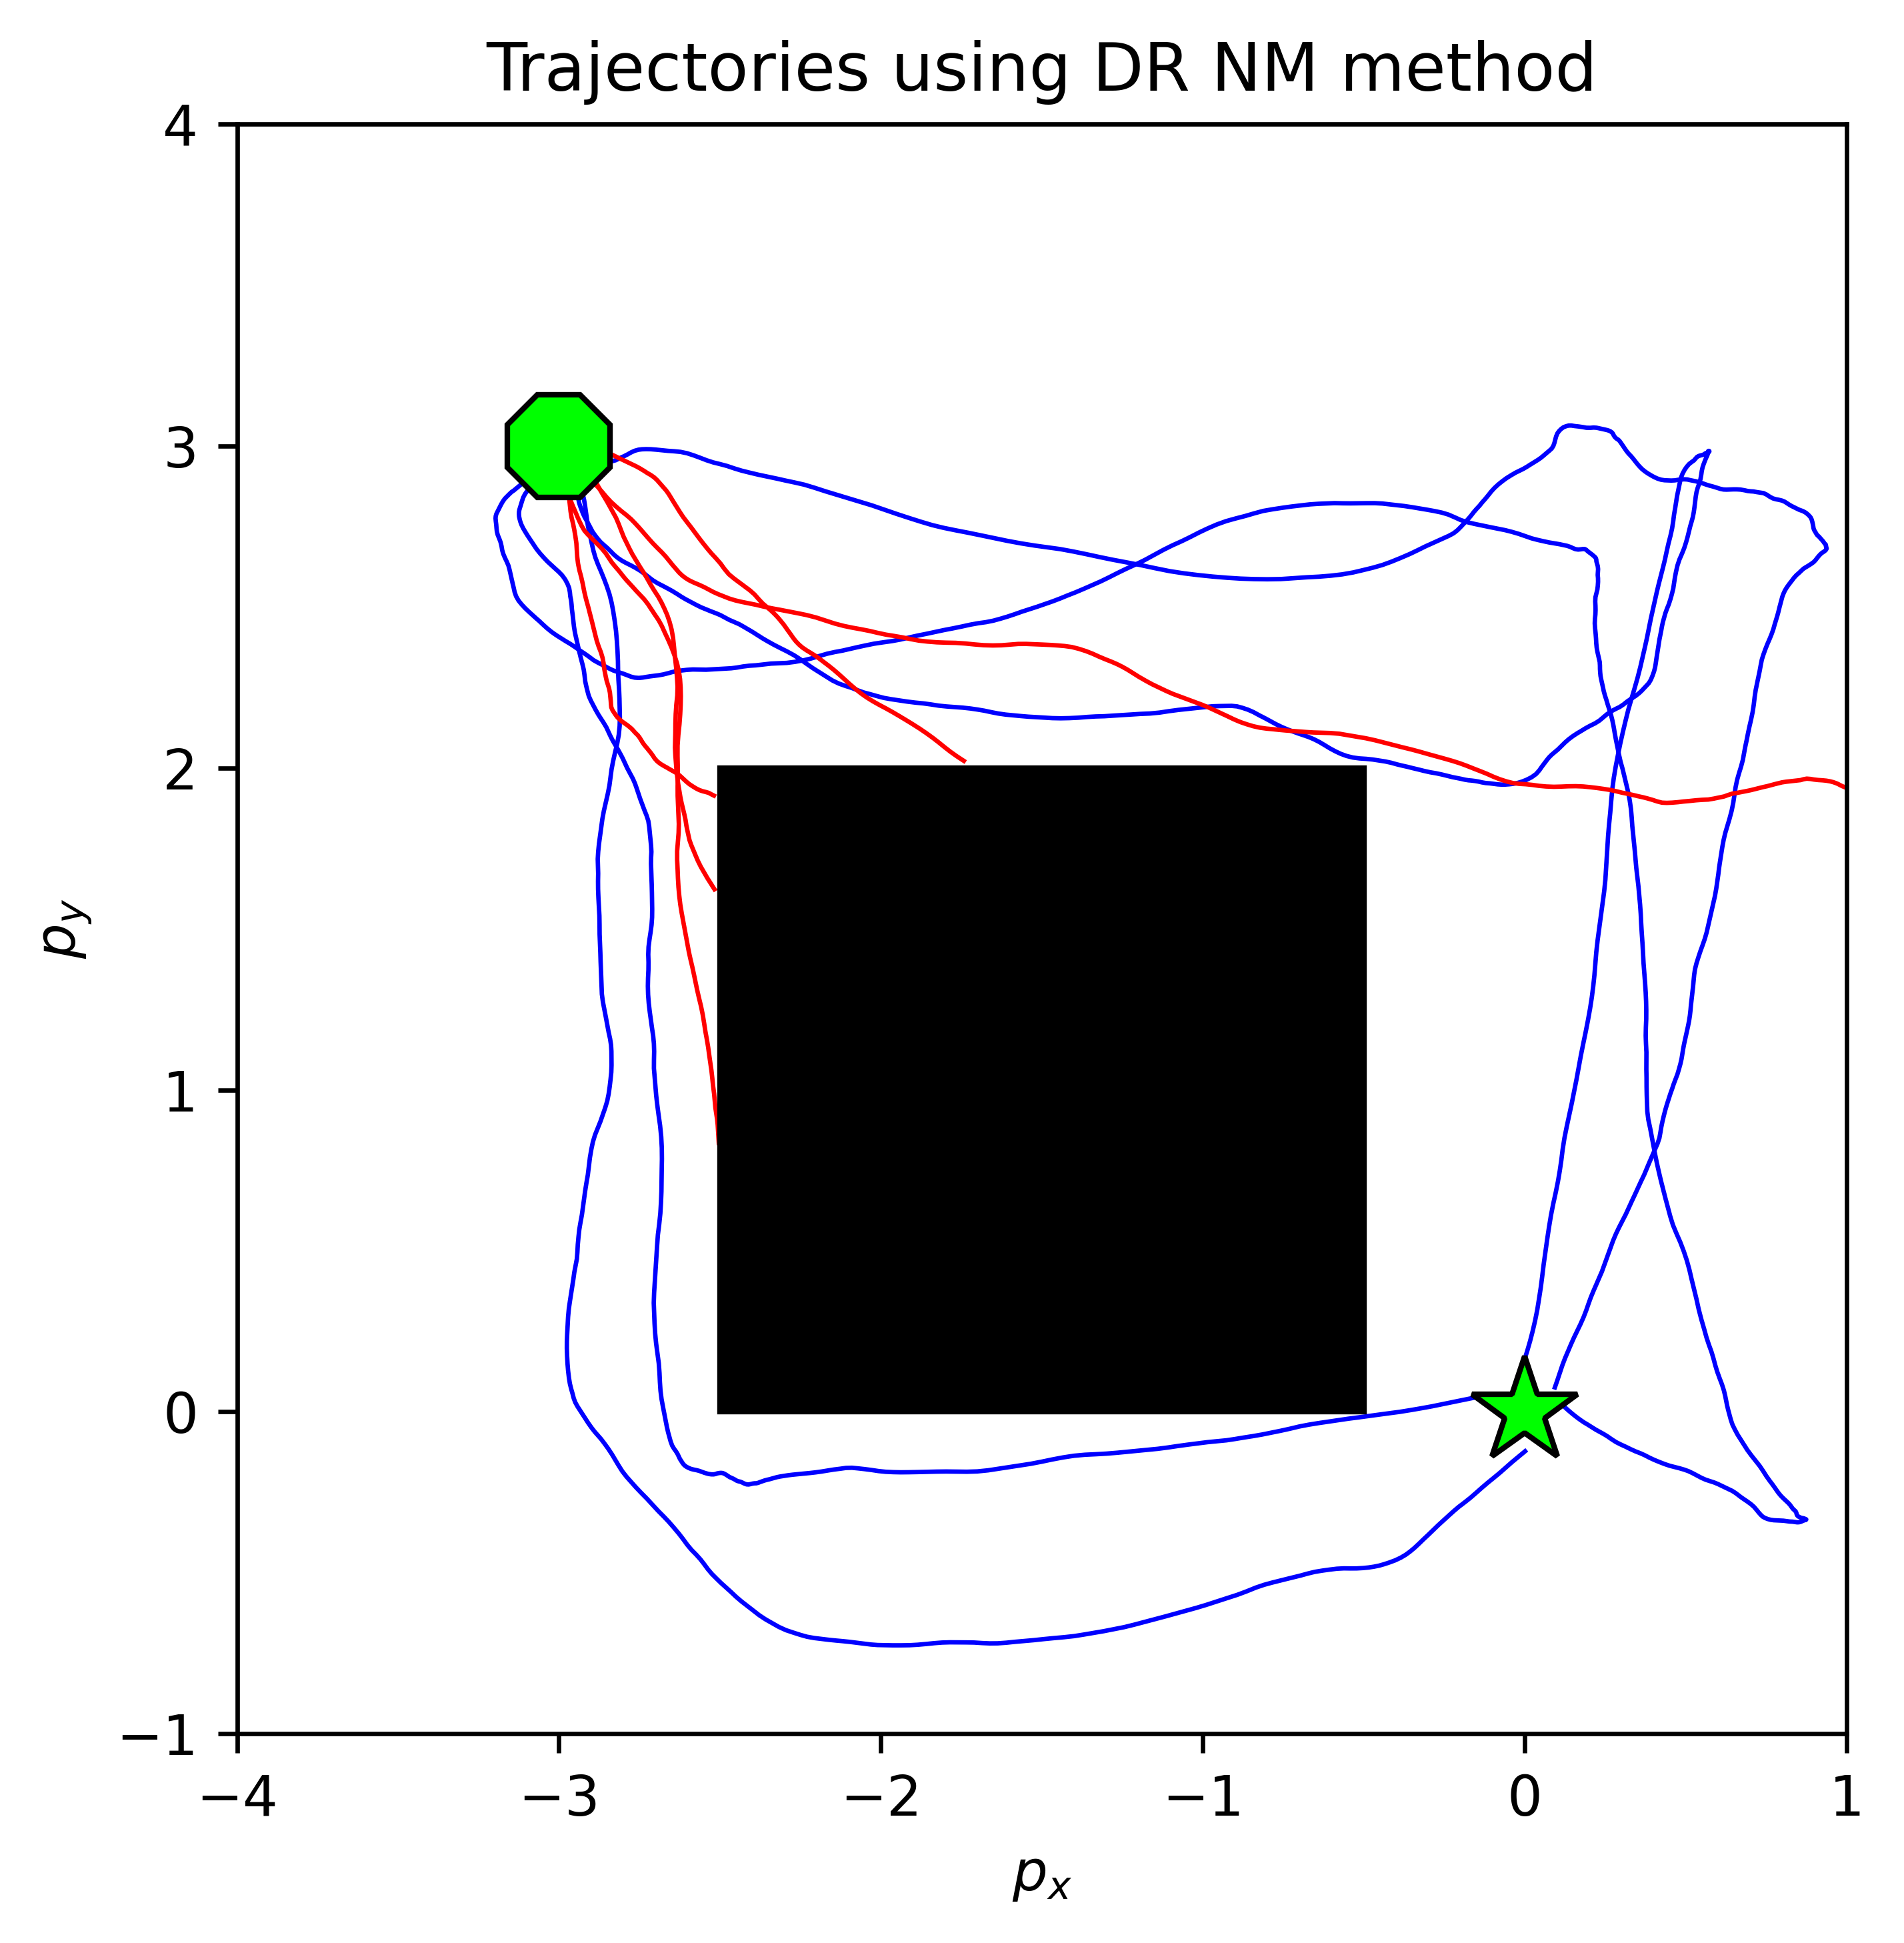

In [114]:
# Final Vis and Log Save

fig, ax = plt.subplots()
ax.plot([x_init[0]], [x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
obstacles.plot_obstacles(ax)

ax.set_xlim(obstacles.boundary_x)
ax.set_ylim(obstacles.boundary_y)
ax.set_xlabel(r'$p_{x}$')
ax.set_ylabel(r'$p_{y}$')
plt.gcf().set_dpi(600)
ax.set_aspect('equal')
plt.tight_layout()

ax.plot(x_hists[success_index,:,0].T, x_hists[success_index,:,1].T, 'b', linewidth=0.8)
ax.plot(x_hists[fail_index,:,0].T, x_hists[fail_index,:,1].T, 'r', linewidth=0.8)
ax.set_title(f'Trajectories using {method} method')

# Save the plot with the current time as the filename
filename = os.path.join("./log", f"plot_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename)

plt.show()
